<a href="https://colab.research.google.com/github/GitWahome/Modern-Computational-Statistics/blob/master/FP_MCS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pystan
import math
from IPython.display import display, HTML
#!pip install -Iv arviz==0.2.1
import arviz as az

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
# --- preliminaries
import pystan.diagnostics as psd
import arviz as az
import sys

sys.path.append( './bin' )


I did the default challengem Mauna Loa.

In [199]:
#print(az.style.available)
az.style.use('fivethirtyeight')
graph_dir = './graphs/simple-regression-'
# --- get and package-up the data

addr = 'https://raw.githubusercontent.com/GitWahome/Modern-Computational-Statistics/master/CSV_weekly_in_situ_co2_mlo.csv'
h_data = 'http://users.stat.ufl.edu/~winner/data/nhl_ht_wt.csv'
df = pd.read_csv(addr,encoding='windows-1252', header=0)
display(df.head())

START DATE  C02 Levels
0  1958-03-29      316.19
1  1958-04-05      317.31
2  1958-04-12      317.69
3  1958-04-19      317.58
4  1958-04-26      316.48

# APPROACH 1 SIMPLE LINEAR  REGRESSION OVER THE WHOLE DATASET.

Let me first explain my data manipulation.



In [200]:
from datetime import date, datetime
def add_day(df=df):
  def get_yearday(day):
      return day.timetuple().tm_yday
  day = []
  for i in range(len(df)):
    day.append(get_yearday(datetime.strptime(df['START DATE'][i], '%Y-%m-%d'))+365.25*(int(df['START DATE'][i][:4])-1958))


  df['DAYS PASSED'] = day


  display(df.head())
  
add_day()

START DATE  C02 Levels  DAYS PASSED
0  1958-03-29      316.19         88.0
1  1958-04-05      317.31         95.0
2  1958-04-12      317.69        102.0
3  1958-04-19      317.58        109.0
4  1958-04-26      316.48        116.0

In [0]:

x = df['DAYS PASSED'].astype(float).values
y = df['C02 Levels'].astype(float).values
#x_mat = np.array([x1,x2,x3,x4,x5])
data = {'r': len(x),'mu':np.mean(x),'sigma':np.std(x) ,'t':x.transpose(), 'y': y}


This would add 4 more variables that I would incorporate into my multiple regression. I would define my function as:

***With DAYS PASSED(X) as t, I will  fit in my linear model as follows: N(Noise +B1t +B2cos(2pi t/365 +B3), B4) ***

This captures the 3 components that were asked: The seasonal variation, the noise and the overall trend over weeks passed.

In [202]:
display(df.head())

START DATE  C02 Levels  DAYS PASSED
0  1958-03-29      316.19         88.0
1  1958-04-05      317.31         95.0
2  1958-04-12      317.69        102.0
3  1958-04-19      317.58        109.0
4  1958-04-26      316.48        116.0

Direct inspection makes it quite obvious that  the data  has a generally (slightly) exponential trend.

I however, wanted to make use of a linear model thus I took the logarithm of the CO2 levels.. This should allow us to validly make use of the linear model, determine the parameters for thes.

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


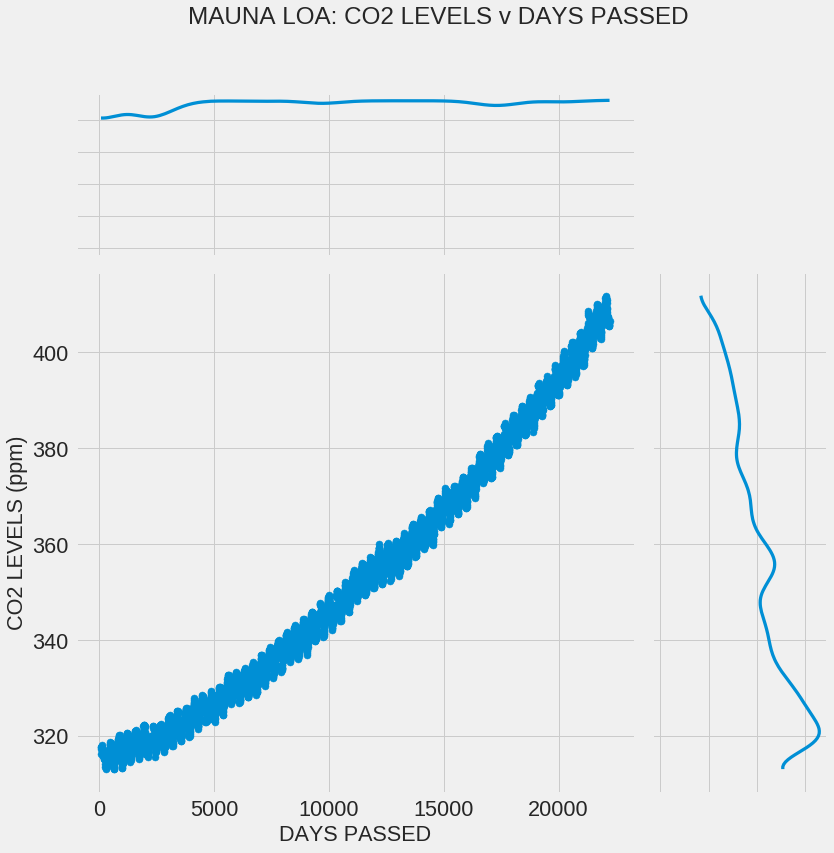

In [203]:
def plot_data(x, y):
  # --- look at the data
  azd={'DAYS PASSED':x,'CO2 LEVELS (ppm)':y}
  az.plot_joint(azd, figsize=(12,12))
  fig = plt.gcf()
  fig.suptitle('MAUNA LOA: '+
  'CO2 LEVELS v DAYS PASSED', size='xx-large')
  fig.tight_layout(pad=1)
  fig.savefig('joint.png', dpi=125)
plot_data(x, y)

From the CO2 LEVELS suplimentary plot on the right(Apologies they are not labeled, I needed them just to give me an idea of the distribution of the data), we can tell most of the coefficient of the days passed will be sampled from a non infomative uniform prior. The beta coefficients will be sampled from a gamma distribution. The alpha and beta parameters for this will be estimated by a normal distribution with the mean and st


In [0]:
model = """
    data {
      // from Python
      int<lower=1> r; // design matrix row num
      real mu; 
      real sigma;
      matrix[r,1] t; // the design matrix
      vector[r] y; // response vector - quality
    }
    parameters {
      // will be returned to Python
      vector[1] c2;
      real c3;
      real<lower=0> c0; //Noise
      vector[1] c1;
      real<lower=0> sig; // must be +ve
    }
    model {
      // Note: priors set with reference to
      // the data to be weakly informative.
      c0 ~ normal(0, 365.25); //Noise
      c1 ~ normal(0, sigma);
      c2 ~ normal(0, sigma);
      c3 ~ normal(0, sigma);
      sig ~ normal(0, sigma); // half Cauchy
      y ~ normal(c0 + t*c1 + cos(((2* 3.142 *t)/365.25)+c3)*c2 , sig * sig);
}
  """

In [205]:
# --- get the Stan model code
# --- compile and run the Stan model
model = pystan.StanModel(model_code=model)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_67482ab00170209e25c4ba7efe29cf78 NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpqwnvfimj/stanfit4anon_model_67482ab00170209e25c4ba7efe29cf78_6105400925485738399.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [206]:
data = {'r': len(x),'mu':np.mean(x),'sigma':np.std(x) ,'t':np.array(list(x)).reshape(len(x), 1), 'y': y}
fit = model.sampling(data=data, iter=2000, chains=4)
samples = fit.extract()


In [207]:
def main_diag(x, fit):
  # --- always check the diagnostics
  import pystan.diagnostics as psd
  d = pd.Series(psd.check_hmc_diagnostics(fit))
  print(d) # --- False indicates a problem
  if not d.all():
    print(fit.stansummary())
main_diag(x, fit)


n_eff         False
Rhat          False
divergence     True
treedepth     False
energy         True
dtype: bool
Inference for Stan model: anon_model_67482ab00170209e25c4ba7efe29cf78.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c2[1]  -1.43    1.76   2.49  -3.04  -2.91  -2.83   0.23   2.98      2  29.51
c3      0.38    0.96   1.36  -2.02  -0.55   1.15   1.18   1.22      2  45.63
c0     306.0  2.4e-3   0.13 305.74 305.92  306.0 306.09 306.27   3085    1.0
c1[1] 4.3e-3  1.8e-7 1.0e-5 4.2e-3 4.3e-3 4.3e-3 4.3e-3 4.3e-3   3435    1.0
sig      1.9  3.8e-4   0.01   1.87   1.89    1.9    1.9   1.92   1010    1.0
lp__   -5496    0.04   1.58  -5500  -5497  -5495  -5495  -5494   1393    1.0

Samples were drawn using NUTS at Thu Dec 20 22:53:44 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential sca


#############################################GENERAL DIAGNOSTICS#############################################

---------------------- inference data for ArviZ-----------------------------

<xarray.Dataset>
Dimensions:  (metric: 7)
Coordinates:
  * metric   (metric) <U22 'mean' ... 'gelman-rubin statistic'
Data variables:
    c0       (metric) float64 306.0 0.1339 0.003375 305.8 306.3 3.085e+03 1.0
    c1       (metric) float64 0.004269 1.027e-05 2.786e-07 ... 3.435e+03 1.0
    c2       (metric) float64 -1.435 2.486 0.8113 -3.042 2.958 2.003 31.86
    c3       (metric) float64 0.3774 1.362 0.445 -2.014 1.224 2.002 49.26
    sig      (metric) float64 1.897 0.01221 0.0003111 1.874 1.92 1.01e+03 1.0

 ---------------------- Further explore diagnostics: ENERGY LEVELS-----------------------------


Any divergences: False

Check energy greater than 0.3 ...
0.9261856445255071

---------------------- Density and trace plot the results-------------------------



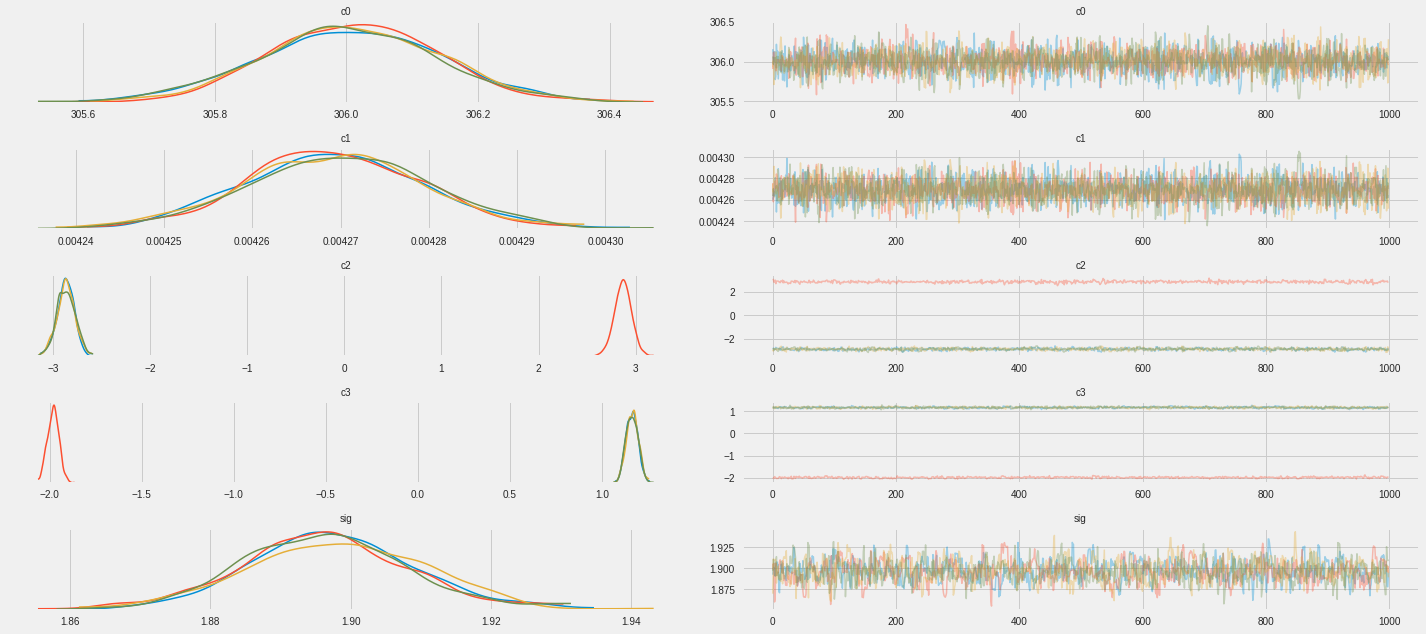


---------------------------Autocorrelation plots------------------------------



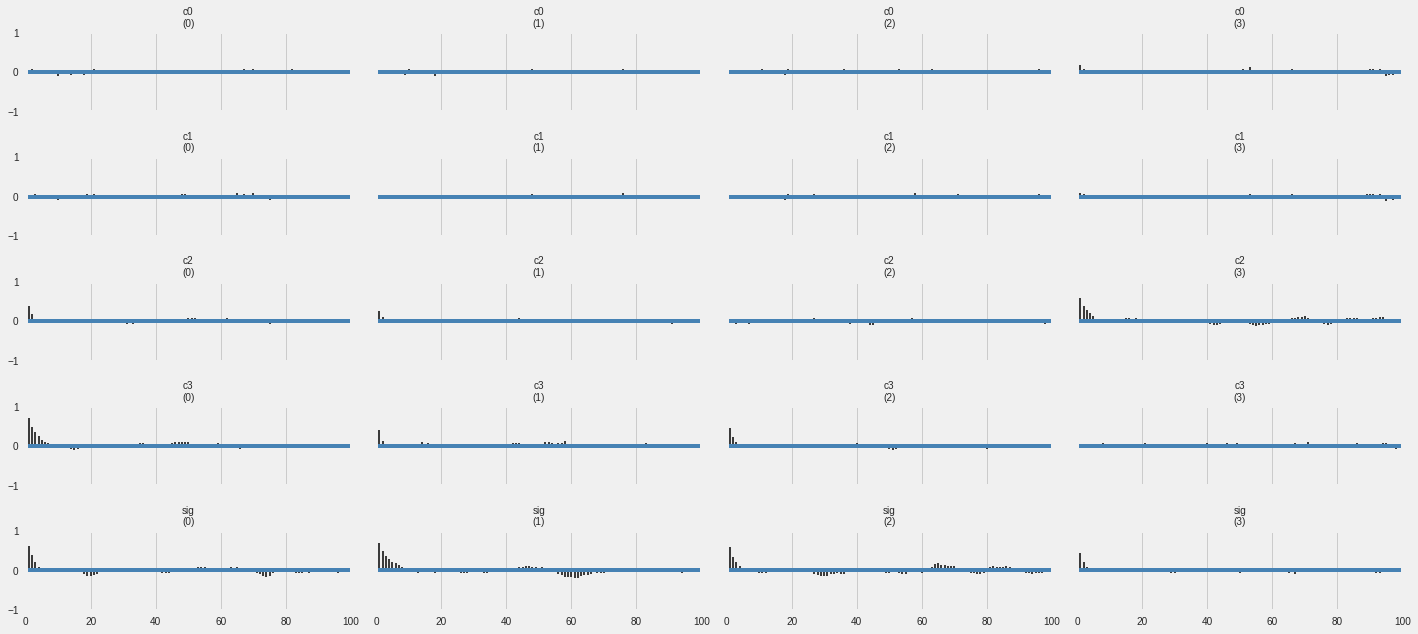


##########################################################################################################


##################################### POSTERIOR PLOTS ########################################



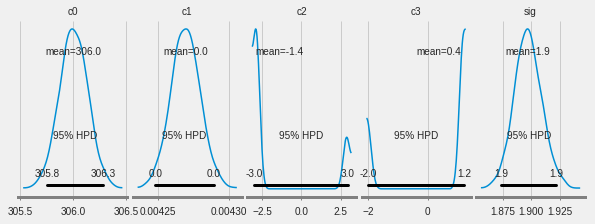


##########################################################################################################



In [208]:
def full_analysis(x, y, fit, samples):
  print("\n#############################################GENERAL DIAGNOSTICS#############################################\n")
  print("---------------------- inference data for ArviZ-----------------------------\n")
  id = az.from_pystan(fit=fit)
  # --- print key results
  params = ['c0', 'c1', 'c2','c3', 'sig']
  print(az.summary(id, params))

  print("\n ---------------------- Further explore diagnostics: ENERGY LEVELS-----------------------------\n")

  d = id.sample_stats.diverging.values.any()
  print('\nAny divergences: {}'.format(d))
  if d :
    az.plot_pair(id, params,
    divergences= True, figsize=(8,8))
    fig = plt.gcf()
    fig.savefig('divergent.png', dpi=125)
    plt.close()
  print('\nCheck energy greater than 0.3 ...')
  e = az.bfmi(id.sample_stats.energy).min()
  print(e)
  if e < 0.4:
    az.plot_energy(id)
    fig = plt.gcf()
    fig.set_size_inches(8, 4)
    fig.tight_layout(pad=1)
    fig.savefig('enery.png', dpi=125)

  print("\n---------------------- Density and trace plot the results-------------------------\n")

  # 
  az.plot_trace(id, var_names=params)
  fig = plt.gcf()
  fig.set_size_inches(20, 9)
  fig.tight_layout(pad=1)
  fig.savefig('trace.png', dpi=125)
  plt.show()

  print("\n---------------------------Autocorrelation plots------------------------------\n")


  # --- auto-correlation plot
  az.plot_autocorr(fit, var_names=['c0', 'c1', 'c2','c3', 'sig'])
  fig = plt.gcf()
  fig.set_size_inches(20, 9)
  fig.tight_layout(pad=1)
  fig.savefig('acf.png', dpi=125)
  plt.show()

  print("\n##########################################################################################################\n")

  print("\n##################################### POSTERIOR PLOTS ########################################\n")
  # --- posterior plots

  az.plot_posterior(id, var_names=params,
  credible_interval=0.95)
  fig = plt.gcf()
  fig.set_size_inches(8, 3)
  fig.savefig('post.png', dpi=125)
  plt.show()

  print("\n##########################################################################################################\n")
  
full_analysis(x, y, fit, samples)

REGRESSION LINE: y= 0.004269181389621856x + 306.0039063217701
Model fitted: y =  306.0039063217701 + x * 0.004269181389621856+ np.cos(((2* 3.142 * x)/365.25)+1.1480833064102045) * -2.8307374517568826 



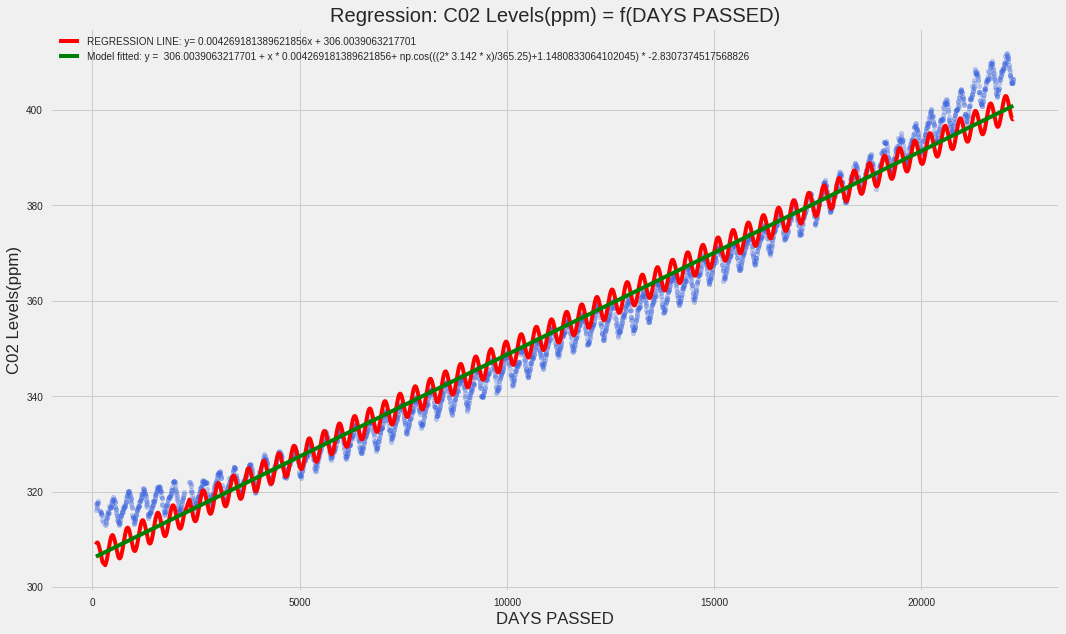

In [209]:
def regression_plot(x, fit):
  # --- scatter plot with regression line(s)
  dF = pd.DataFrame({'DAYS PASSED':x, 'C02 Levels':y})
  ax = dF.plot.scatter(x='DAYS PASSED', y='C02 Levels',
  color='royalblue', alpha=0.3)
  c0 = np.median(samples['c0'])
  c1 = np.median(samples['c1'])
  c2 = np.median(samples['c2'])
  c3 = np.median(samples['c3'])
  print(f"REGRESSION LINE: y= {c1}x + {c0}")
  print(f"Model fitted: y =  {c0} + x * {c1}+ np.cos(((2* 3.142 * x)/365.25)+{c3}) * {c2} \n")
  linear= lambda t: c0 + t * c1+ np.cos(((2* 3.142 *t)/365.25)+c3) * c2
  reg_line = lambda t: c1*t +c0
  ax.plot(x,[linear(xi) for xi in x], color ="red")
  ax.plot(x,[reg_line(xi) for xi in x], color ="green")
  ax.set_title('Regression: C02 Levels(ppm) = f(DAYS PASSED)')
  ax.set_ylabel('C02 Levels(ppm)')
  ax.set_xlabel('DAYS PASSED')
  ax.legend([f"REGRESSION LINE: y= {c1}x + {c0}",f"Model fitted: y =  {c0} + x * {c1}+ np.cos(((2* 3.142 * x)/365.25)+{c3}) * {c2}"])
  fig = ax.figure
  fig.set_size_inches(15, 9)
  fig.tight_layout(pad=1)
  fig.savefig('scatter.png', dpi=125)
  
regression_plot(x, fit)

The first simulation above is what we get when we run the model on the whole dataset. I have included the correlation plots and convergence indicators rhat and nef in my output. While some of the coefficients converged, some of them did not. This tells us that the NUTS sampler got stuck when sampling. These are the values for C2 and C3. C2 scale the season variation. The scaling is has multiple peaks since they need to scale the variation in both up and down hence why the sample would probably get stuck in one of the modes.  While this issue might be fixed by adjusting the treedept or stepsize, I though my approximations were relatively good and since I was going to work on new models anyway, I did not dwell on this. I judged the model fitting vidually.  We have our model equations and from the outputsthe hyperparameter needed to create a sample for the future.  i understand I should be doing this in cpp using stan but this was taking too long so I did manually using the infered parameters.  

Our diagnostics also show relatively low autocorrelation thus despite some of the coefficients being stuck, in some instances, (Talking to you sig and c2), they are still low enough to assume no interdependece amongs the sampled data points. 

In [210]:
def norm_lg(x):
  # --- compare with classic regression
  import statsmodels.api as sm
  xc = sm.add_constant(x)
  #xd = sm.add_constant(x)
  model = sm.OLS(y, xc).fit()
  print(model.summary())
  
norm_lg(x)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 1.322e+05
Date:                Thu, 20 Dec 2018   Prob (F-statistic):               0.00
Time:                        22:53:54   Log-Likelihood:                -8767.9
No. Observations:                3091   AIC:                         1.754e+04
Df Residuals:                    3089   BIC:                         1.755e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        305.9895      0.152   2012.991      0.0

I did a classic regression for comparison purposes and clearly,, our estimation is relatively accurate. In fact, it is really good having missed the intercept by less than 0.5 and the slope by 0.001. This is a great linear fit. The seasonal variation is what had a variation but this is because we assume a linear relationship yet the data is clearly quadratic though slightly. To get a more accurate estimate, I will chunk the data and see how the gradient changes then attempt to infer the next line from the trend. One assumption I make though is that the rate of change is regular. In fact, I am thinking of this rise as being somehwat 'circular'. I will plot the regression lines to showcase  the way I estimate the curve using the lines and also add the predicted lines for the next 50 years. This is what I will use to predict the next 50 year data.

# APPROACH 2: IMPROVEMENT: MULTIPLE LINEAR MODEL ON CHUNKS OF 4500 DAYS.

From the whole model above, The data is clearly slightly quadratic. I apologize for my cheating but I actually looked up the exact formula to try and guide my new model. My quadratic attempts failed me so when I ran out of time I opted to reuse the simpler linear model I have. My linear model really fit well for data within chunks of 12 years. I figured that if I performed the regression on these chunks, I could very  easily see how the trend in the covariates and from this, manually approximate the updates needed to create a predictive model for the start of 1958.  I know this appoach sucks as I now have a model that will lose value the next year and totally understand the 2 or 1 that comes with this cheating.

Either way, this approach allows me to have a relatively more accurate model than the one that takes into account the whole dataset. The linear model is also simple to compute and the smaller datasets made this faster to work with.

## Chunks

Asubset of about 618 values corresponds to about 12 years. We can divide our data into 5 susch chunks. The regression is able to fit models into chunks of this size way better. I computed five models. The subdatasets are as follows:

df1 = 0-618,

df2 = 619-1237

df3 = 1258 - 1856

df4 = 1857-2475

df5 = 2476 - 3094

**N(Noise B1t+B2^X +B2cos(2pi t/365 +B3), B4)**

In [0]:
flen = len(df)
fift = flen//5
df1 = df[:fift]
df2 = df[fift:2*fift]
df3 = df[2*fift+1:3*fift]
df4 = df[3*fift +1:4*fift]
df5 = df[4*fift:]

# CHUNK 1

In [0]:
df =df1
x = df['DAYS PASSED'].astype(float).values
y = df['C02 Levels'].astype(float).values
#x_mat = np.array([x1,x2,x3,x4,x5])
data = {'r': len(x),'mu':np.mean(x),'sigma':np.std(x) ,'t':x.transpose(), 'y': y}

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


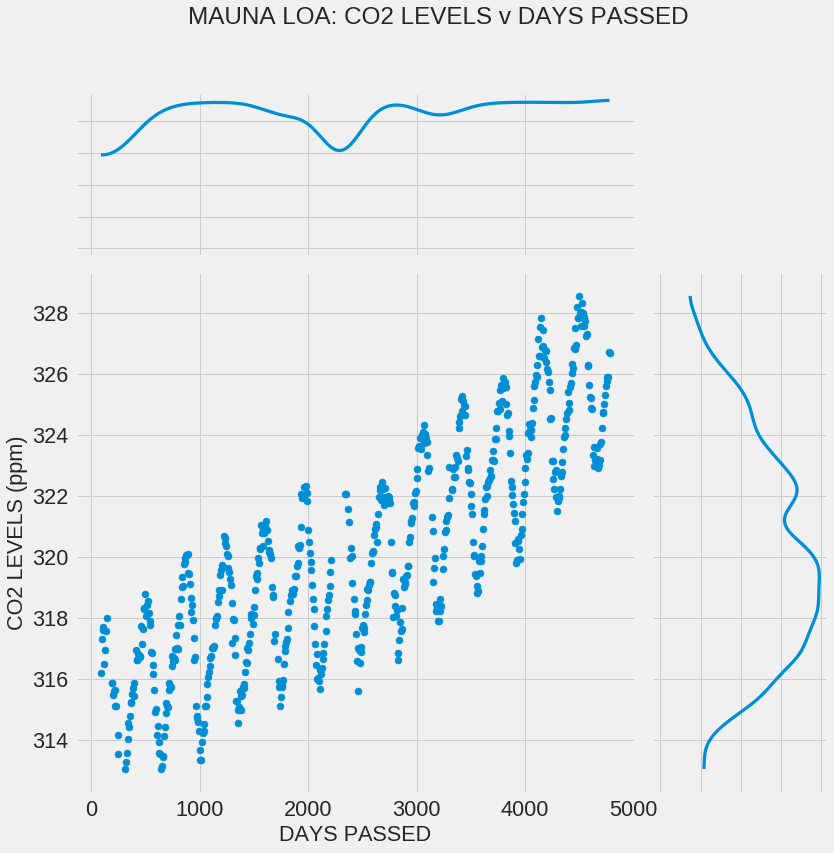

In [213]:
plot_data(x, y)

In [214]:
data = {'r': len(x),'mu':np.mean(x),'sigma':np.std(x) ,'t':np.array(list(x)).reshape(len(x), 1), 'y': y}
fit = model.sampling(data=data, iter=2000, chains=4)
samples = fit.extract()

In [215]:
main_diag(x, fit)

n_eff         False
Rhat          False
divergence     True
treedepth     False
energy         True
dtype: bool
Inference for Stan model: anon_model_67482ab00170209e25c4ba7efe29cf78.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c2[1]  -1.29    1.59   2.25  -2.67  -2.61  -2.57   0.25   2.65      2  55.87
c3      1.95    0.96   1.36   1.13   1.15   1.17   2.88   4.32      2  87.19
c0    314.56  1.0e-3   0.06 314.43 314.51 314.56  314.6 314.69   3961    1.0
c1[1] 2.3e-3  3.7e-7 2.3e-5 2.2e-3 2.3e-3 2.3e-3 2.3e-3 2.3e-3   3817    1.0
sig     0.87  2.7e-4   0.01   0.84   0.86   0.87   0.88   0.89   1939    1.0
lp__  -127.2    0.04   1.61 -131.2 -128.0 -126.9 -126.0 -125.1   1492    1.0

Samples were drawn using NUTS at Thu Dec 20 22:59:03 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential sca


#############################################GENERAL DIAGNOSTICS#############################################

---------------------- inference data for ArviZ-----------------------------

<xarray.Dataset>
Dimensions:  (metric: 7)
Coordinates:
  * metric   (metric) <U22 'mean' ... 'gelman-rubin statistic'
Data variables:
    c0       (metric) float64 314.6 0.0646 0.0006953 314.4 314.7 3.961e+03 1.0
    c1       (metric) float64 0.00229 2.256e-05 2.559e-07 ... 3.817e+03 1.0
    c2       (metric) float64 -1.294 2.245 0.8979 -2.672 2.634 2.002 60.28
    c3       (metric) float64 1.947 1.36 0.5439 1.128 4.318 2.001 93.99
    sig      (metric) float64 0.8679 0.01189 0.0002572 ... 0.8882 1.938e+03 1.0

 ---------------------- Further explore diagnostics: ENERGY LEVELS-----------------------------


Any divergences: False

Check energy greater than 0.3 ...
1.043318183217465

---------------------- Density and trace plot the results-------------------------



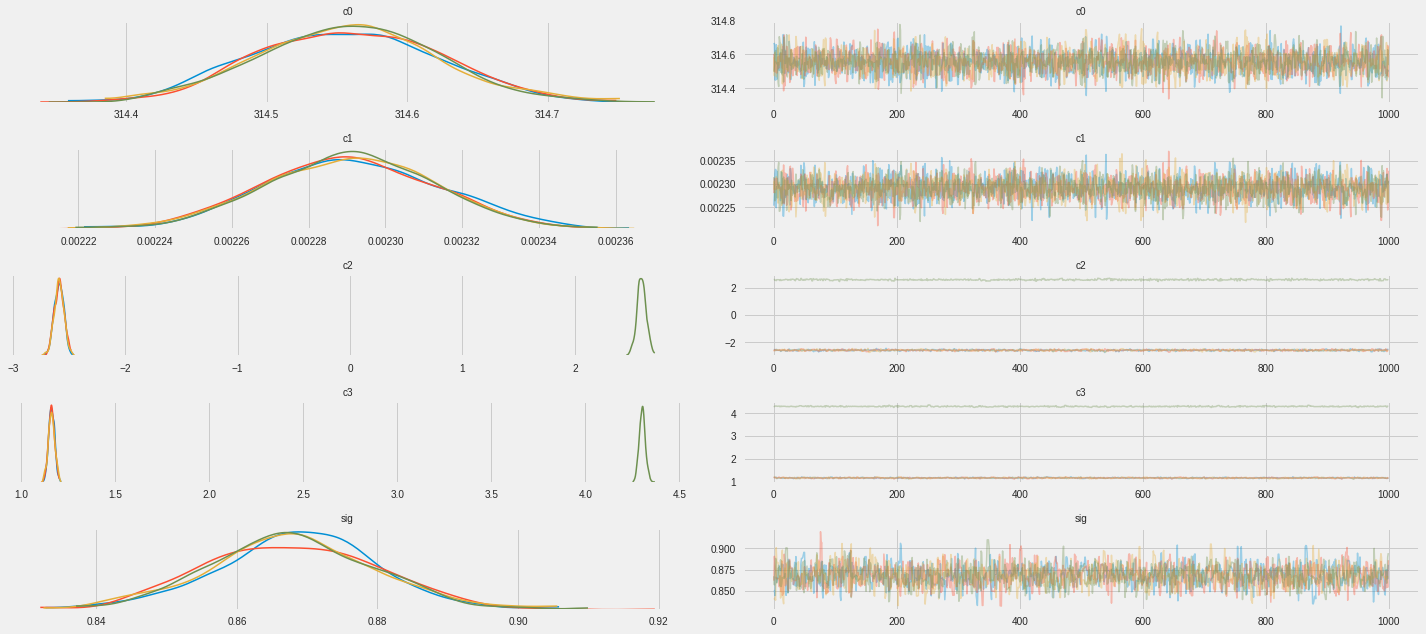


---------------------------Autocorrelation plots------------------------------



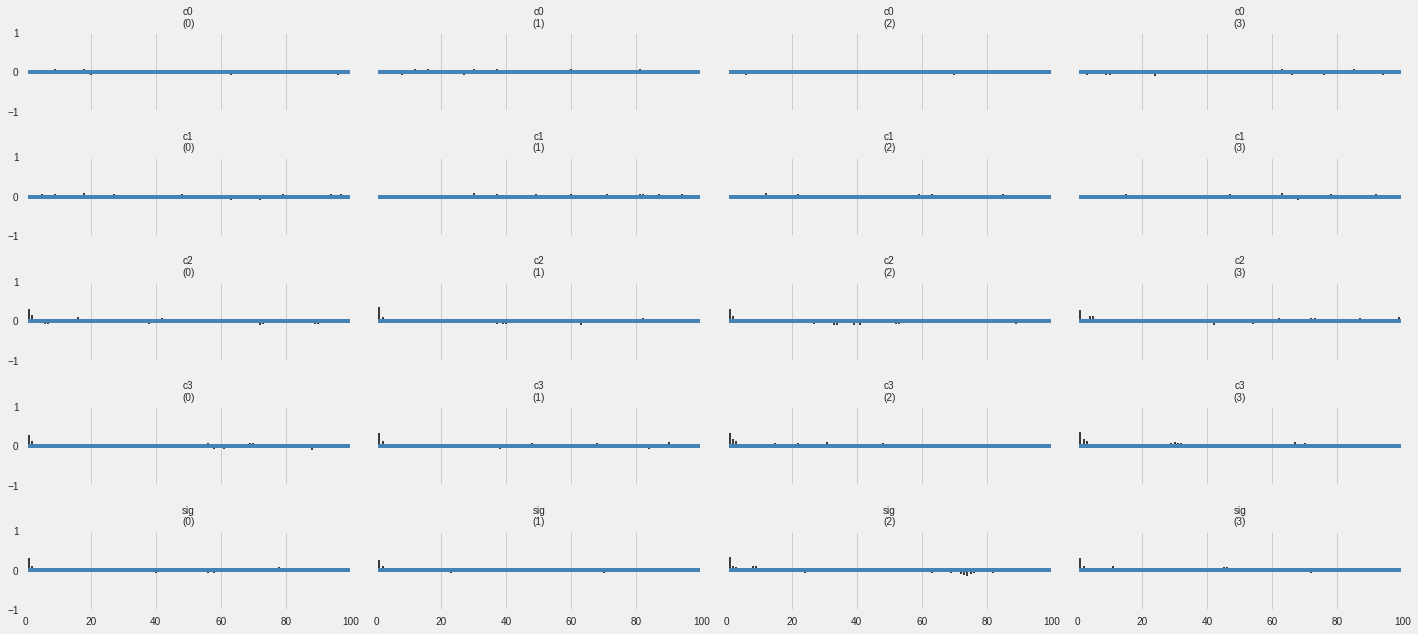


##########################################################################################################


##################################### POSTERIOR PLOTS ########################################



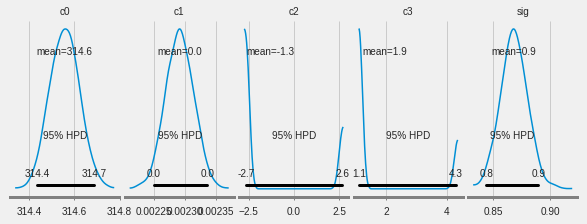


##########################################################################################################



In [216]:
  full_analysis(x, y, fit, samples)

REGRESSION LINE: y= 0.0022905500081122424x + 314.556717361755
Model fitted: y =  314.556717361755 + x * 0.0022905500081122424+ np.cos(((2* 3.142 * x)/365.25)+1.1685491360976519) * -2.571065998069873 



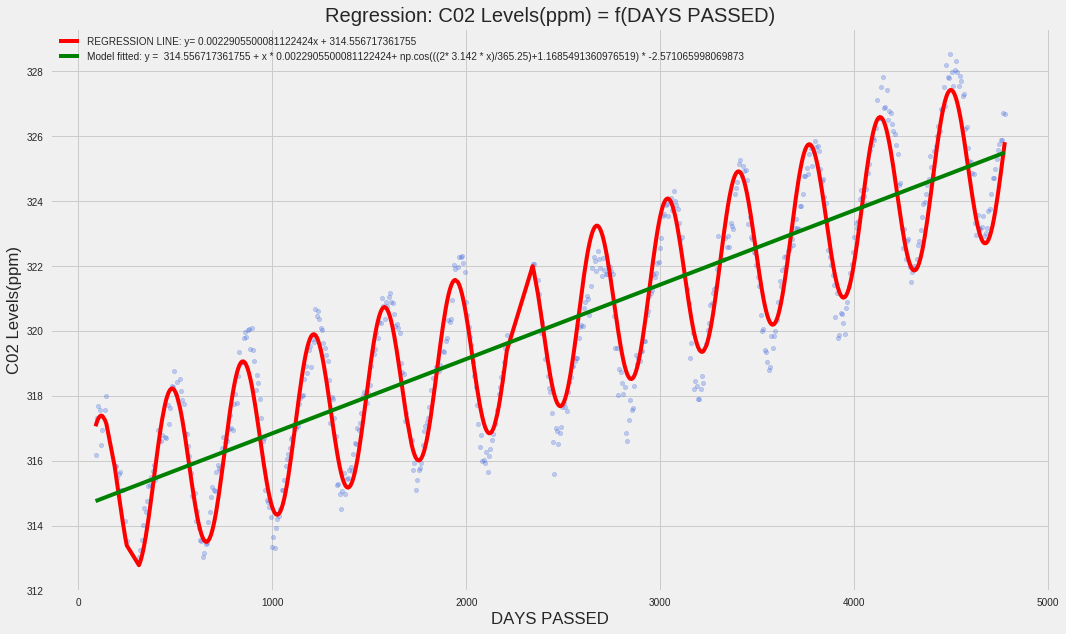

In [217]:
regression_plot(x, fit)

This is a similar case to our main case, the model is the same. We have our fist regression line infered. I will generate the for the different sections.
As we can see, this fit is waay better than that on the whoke dataset. The autocorrelations are similar to the main model and this will the same case observed all through. Generally, the estimates made are better when we fit the model on smaller datasets.

We can tell convergence happened on Covariates like c0, c1 and sig.

In [218]:
norm_lg(x)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     1425.
Date:                Thu, 20 Dec 2018   Prob (F-statistic):          2.30e-162
Time:                        22:59:13   Log-Likelihood:                -1298.3
No. Observations:                 618   AIC:                             2601.
Df Residuals:                     616   BIC:                             2609.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        314.6825      0.167   1880.881      0.0

# CHUNK 2

In [0]:
df =df2
x = df['DAYS PASSED'].astype(float).values
y = df['C02 Levels'].astype(float).values
#x_mat = np.array([x1,x2,x3,x4,x5])
data = {'r': len(x),'mu':np.mean(x),'sigma':np.std(x) ,'t':x.transpose(), 'y': y}

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


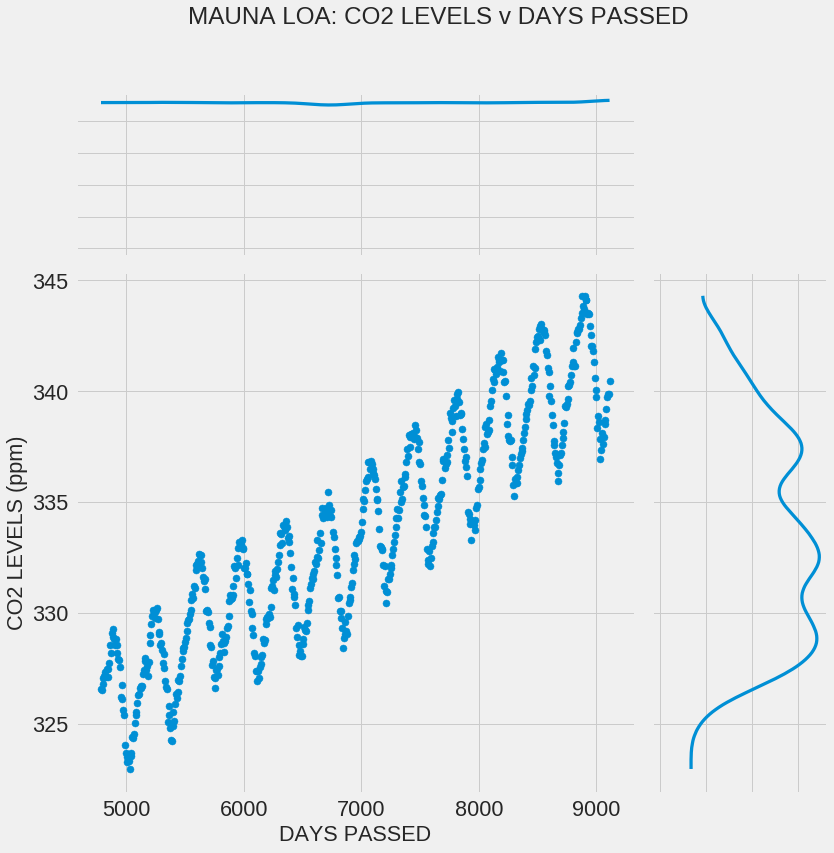

In [220]:
plot_data(x, y)

In [221]:
data = {'r': len(x),'mu':np.mean(x),'sigma':np.std(x) ,'t':np.array(list(x)).reshape(len(x), 1), 'y': y}
fit = model.sampling(data=data, iter=2000, chains=4)
samples = fit.extract()

In [222]:
main_diag(x, fit)

n_eff         False
Rhat          False
divergence     True
treedepth     False
energy         True
dtype: bool
Inference for Stan model: anon_model_67482ab00170209e25c4ba7efe29cf78.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c2[1]   -1.4    1.71   2.42  -2.87  -2.81  -2.78   0.26   2.85      2  61.88
c3      0.37    0.96   1.36  -2.01  -0.57   1.14   1.16   1.18      2  93.87
c0    307.84  3.1e-3   0.18 307.49 307.72 307.84 307.96 308.19   3246    1.0
c1[1] 3.7e-3  4.3e-7 2.5e-5 3.7e-3 3.7e-3 3.7e-3 3.7e-3 3.8e-3   3304    1.0
sig     0.86  4.4e-4   0.01   0.84   0.86   0.86   0.87   0.89    799   1.01
lp__  -122.9    0.04   1.55 -126.7 -123.8 -122.6 -121.7 -120.8   1311    1.0

Samples were drawn using NUTS at Thu Dec 20 23:05:38 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential sca


#############################################GENERAL DIAGNOSTICS#############################################

---------------------- inference data for ArviZ-----------------------------

<xarray.Dataset>
Dimensions:  (metric: 7)
Coordinates:
  * metric   (metric) <U22 'mean' ... 'gelman-rubin statistic'
Data variables:
    c0       (metric) float64 307.8 0.1757 0.001504 307.5 308.2 3.245e+03 1.0
    c1       (metric) float64 0.003708 2.494e-05 2.117e-07 ... 3.304e+03 1.0
    c2       (metric) float64 -1.399 2.422 0.7916 -2.874 2.844 2.001 66.69
    c3       (metric) float64 0.3651 1.36 0.4441 -2.008 1.179 2.001 101.2
    sig      (metric) float64 0.8641 0.01237 0.000244 0.8418 0.8885 798.8 1.0

 ---------------------- Further explore diagnostics: ENERGY LEVELS-----------------------------


Any divergences: False

Check energy greater than 0.3 ...
0.9714937216927525

---------------------- Density and trace plot the results-------------------------



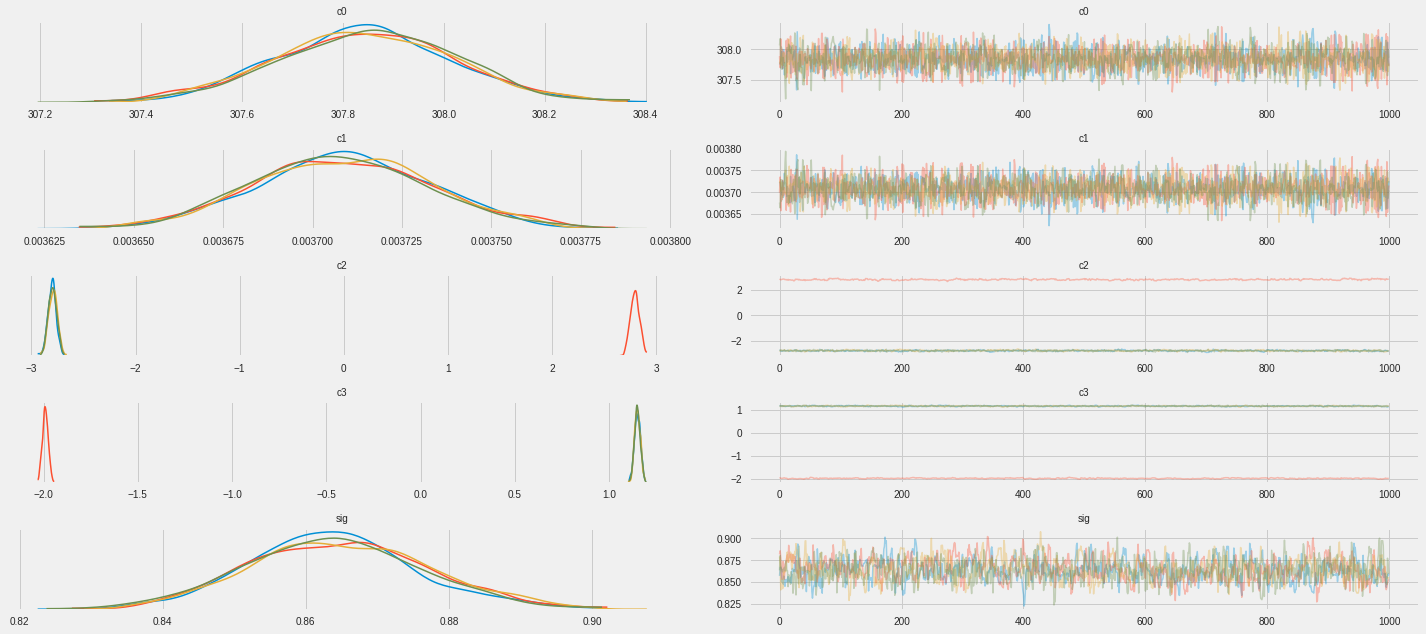


---------------------------Autocorrelation plots------------------------------



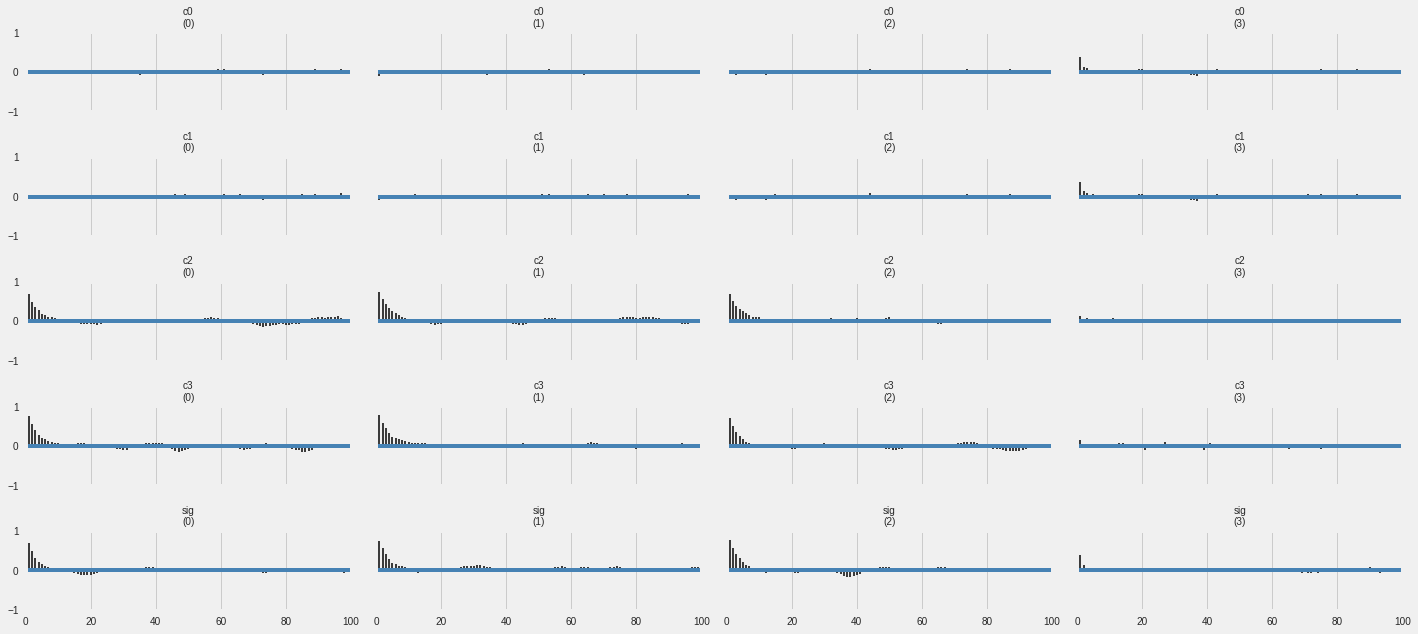


##########################################################################################################


##################################### POSTERIOR PLOTS ########################################



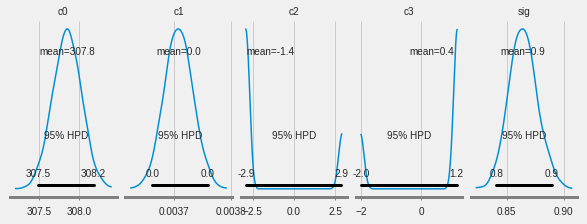


##########################################################################################################



In [223]:
full_analysis(x, y, fit, samples)


REGRESSION LINE: y= 0.0037079517438362865x + 307.84399223487077
Model fitted: y =  307.84399223487077 + x * 0.0037079517438362865+ np.cos(((2* 3.142 * x)/365.25)+1.1436171712372687) * -2.780431440545609 



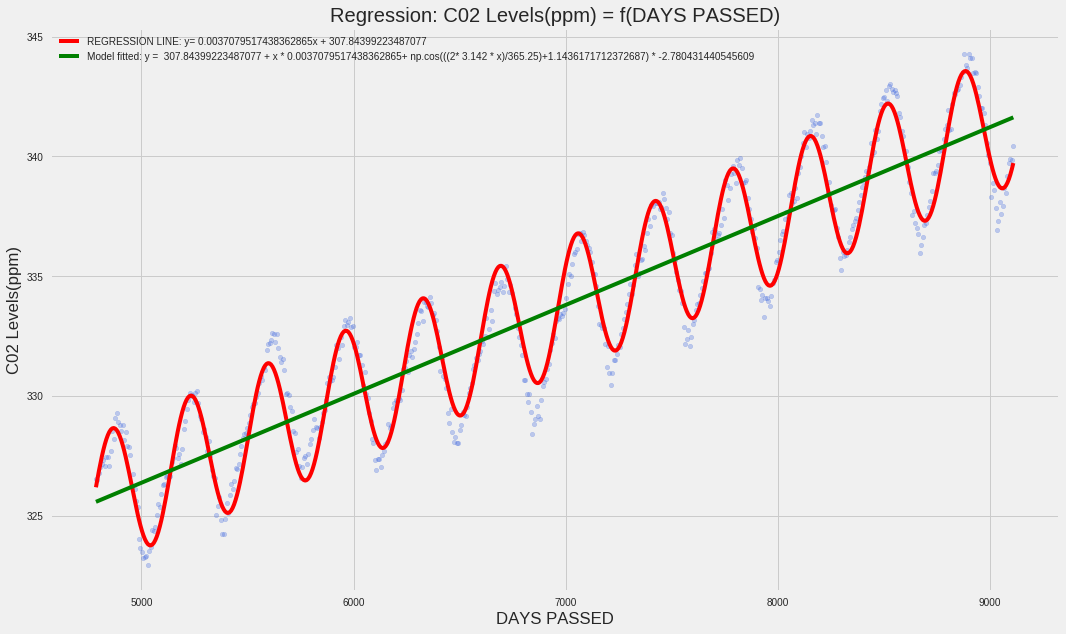

In [224]:
regression_plot(x, fit)

Our third chunk also follows the trend. The fit is better.  The autocorrelations also showcase a similar trend. There is not much of them to make us panick. Also, by visual inspection, the model is relatively good and estimates the data quite well. One thing to observe is that the increase in gradient(The coefficient of x in the rehression line. This is exactly what we are looking for. We want to see the pattern in this rise.) We can also estimate the change in the seasonal variation. i will for simplicity purposes just get significant statistics, generate a uniform distribution and sampe randomly from this. This sould help me keep consistent with the estimation theme. I will use this to project into the future dates.

In [225]:
norm_lg(x)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     2809.
Date:                Thu, 20 Dec 2018   Prob (F-statistic):          1.17e-231
Time:                        23:05:48   Log-Likelihood:                -1341.1
No. Observations:                 618   AIC:                             2686.
Df Residuals:                     616   BIC:                             2695.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        308.4877      0.482    640.449      0.0

# CHUNK 3

In [0]:
df =df3
x = df['DAYS PASSED'].astype(float).values
y = df['C02 Levels'].astype(float).values
#x_mat = np.array([x1,x2,x3,x4,x5])
data = {'r': len(x),'mu':np.mean(x),'sigma':np.std(x) ,'t':x.transpose(), 'y': y}

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


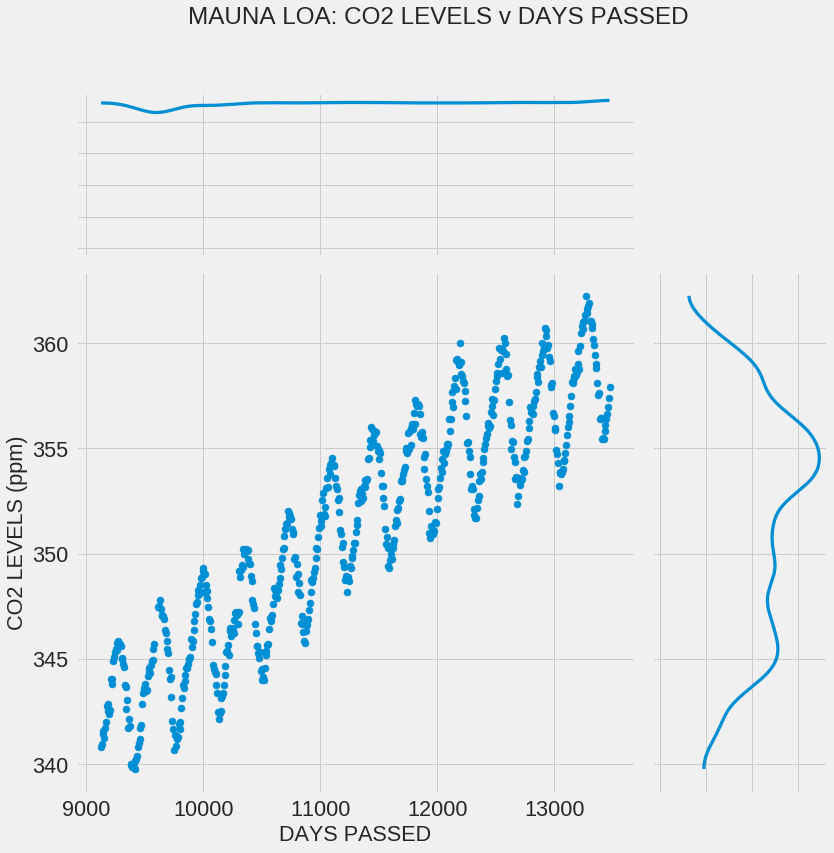

In [227]:
plot_data(x, y)

In [228]:
data = {'r': len(x),'mu':np.mean(x),'sigma':np.std(x) ,'t':np.array(list(x)).reshape(len(x), 1), 'y': y}
fit = model.sampling(data=data, iter=2000, chains=4)
samples = fit.extract()

In [229]:
main_diag(x, fit)

n_eff         False
Rhat          False
divergence     True
treedepth     False
energy         True
dtype: bool
Inference for Stan model: anon_model_67482ab00170209e25c4ba7efe29cf78.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c2[1]   1.49    1.82   2.57  -3.04  -0.29   2.95   2.99   3.07      2  52.29
c3     -1.19    0.96   1.36   -2.0  -1.98  -1.96  -0.25    1.2      2   80.5
c0    305.36  6.3e-3   0.34 304.69 305.13 305.35 305.59 306.03   2935    1.0
c1[1] 4.1e-3  5.6e-7 3.0e-5 4.0e-3 4.0e-3 4.1e-3 4.1e-3 4.1e-3   2952    1.0
sig     0.97  6.4e-4   0.01   0.94   0.96   0.97   0.98    1.0    488   1.01
lp__  -260.7    0.05   1.57 -264.7 -261.5 -260.4 -259.6 -258.6    881    1.0

Samples were drawn using NUTS at Thu Dec 20 23:12:26 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential sca


#############################################GENERAL DIAGNOSTICS#############################################

---------------------- inference data for ArviZ-----------------------------

<xarray.Dataset>
Dimensions:  (metric: 7)
Coordinates:
  * metric   (metric) <U22 'mean' ... 'gelman-rubin statistic'
Data variables:
    c0       (metric) float64 305.4 0.3439 0.004255 304.7 306.0 2.934e+03 1.0
    c1       (metric) float64 0.004058 3.026e-05 3.357e-07 ... 2.952e+03 1.0
    c2       (metric) float64 1.485 2.572 0.8388 -3.031 3.059 2.002 56.5
    c3       (metric) float64 -1.186 1.361 0.4443 -2.004 1.192 2.001 86.86
    sig      (metric) float64 0.9663 0.01403 0.0002574 0.9404 0.993 488.2 1.0

 ---------------------- Further explore diagnostics: ENERGY LEVELS-----------------------------


Any divergences: False

Check energy greater than 0.3 ...
0.9465709226949828

---------------------- Density and trace plot the results-------------------------



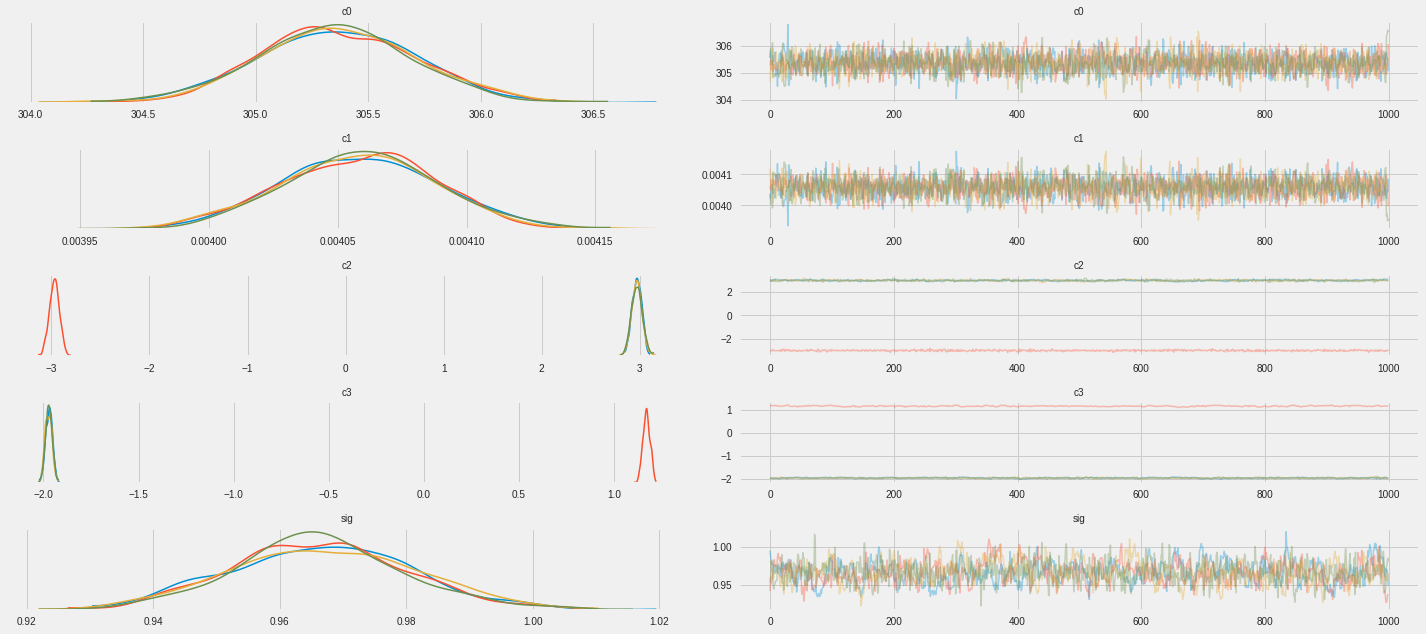


---------------------------Autocorrelation plots------------------------------



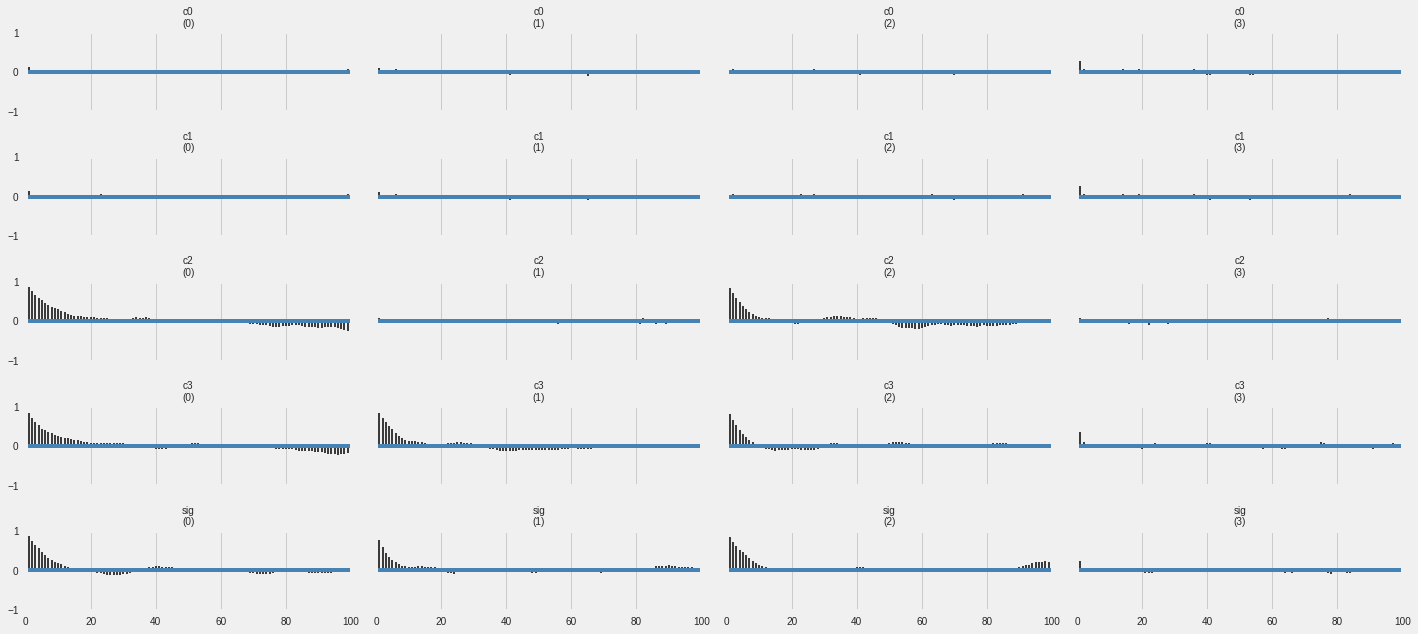


##########################################################################################################


##################################### POSTERIOR PLOTS ########################################



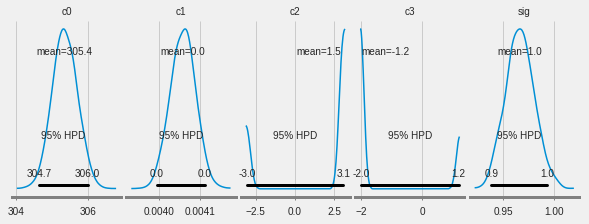


##########################################################################################################



In [230]:
full_analysis(x, y, fit, samples)

REGRESSION LINE: y= 0.004058880316671683x + 305.3506634535947
Model fitted: y =  305.3506634535947 + x * 0.004058880316671683+ np.cos(((2* 3.142 * x)/365.25)+-1.9636040939429324) * 2.947315076682325 



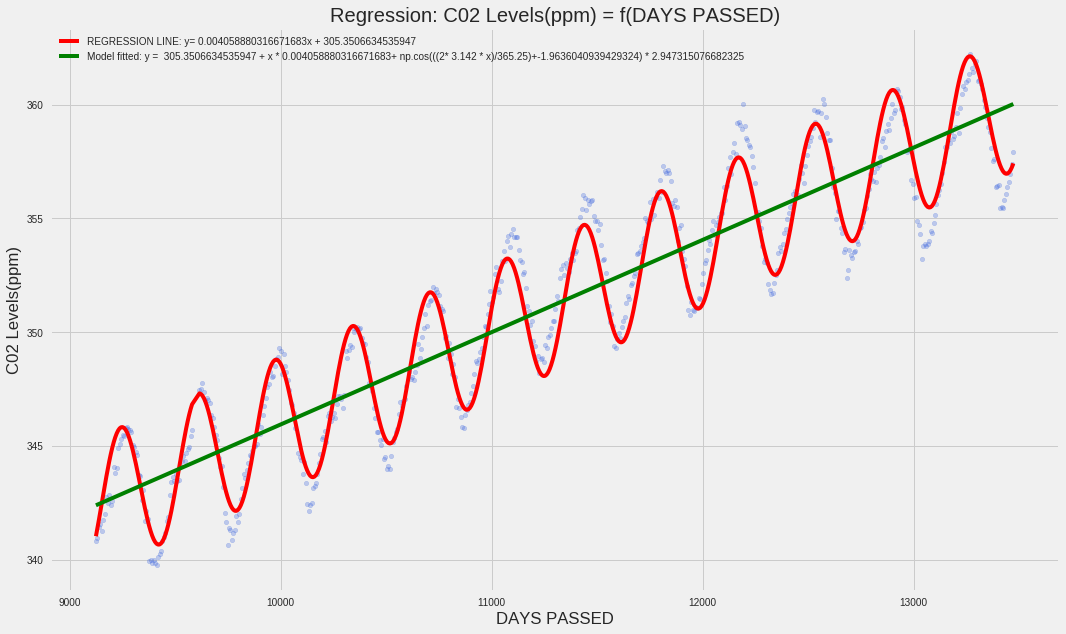

In [231]:
regression_plot(x, fit)

There was a bit of fluctuation in the data which made this linear estimate relatively inaccurate but nonetheless ok. The trend holds, the gradient still increases. The autocorrelations are a bit haywire in this one but they are still workable with and given the fit of the model, the samples generated still suffice when it comes to estimating the regression line. 

The classic regression below validates this inference.

In [232]:
norm_lg(x)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     2945.
Date:                Thu, 20 Dec 2018   Prob (F-statistic):          1.15e-236
Time:                        23:12:36   Log-Likelihood:                -1387.2
No. Observations:                 617   AIC:                             2778.
Df Residuals:                     615   BIC:                             2787.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        305.9930      0.839    364.643      0.0

# CHUNK 4

In [0]:
df =df4
x = df['DAYS PASSED'].astype(float).values
y = df['C02 Levels'].astype(float).values
#x_mat = np.array([x1,x2,x3,x4,x5])
data = {'r': len(x),'mu':np.mean(x),'sigma':np.std(x) ,'t':x.transpose(), 'y': y}

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


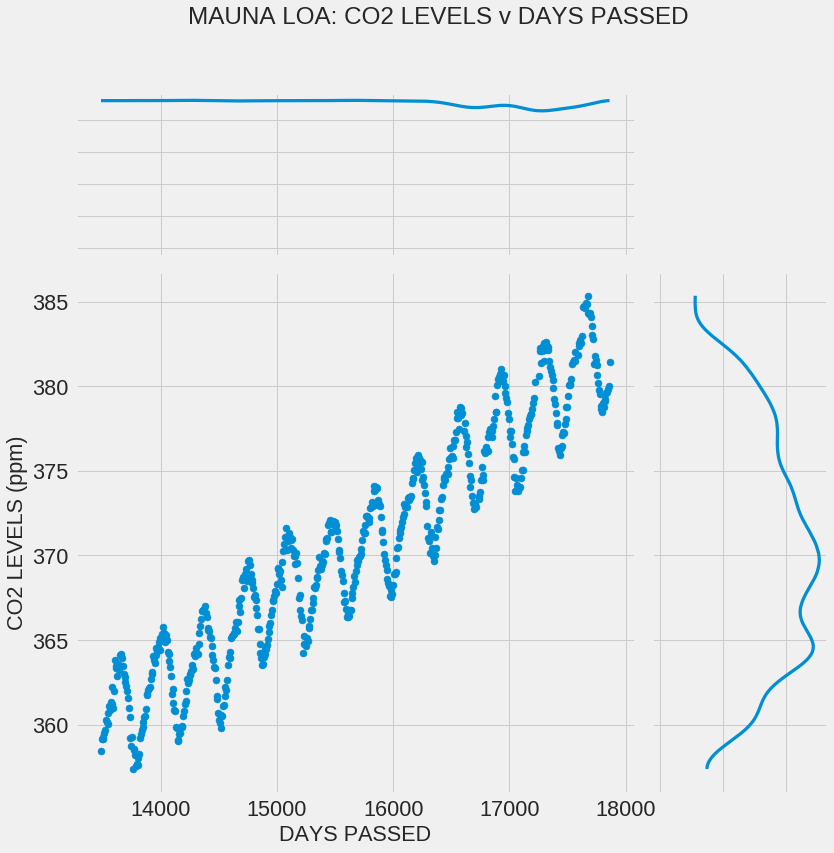

In [234]:
plot_data(x, y)

In [235]:
data = {'r': len(x),'mu':np.mean(x),'sigma':np.std(x) ,'t':np.array(list(x)).reshape(len(x), 1), 'y': y}
fit = model.sampling(data=data, iter=2000, chains=4)
samples = fit.extract()

In [236]:
main_diag(x, fit)

n_eff         False
Rhat          False
divergence     True
treedepth     False
energy         True
dtype: bool
Inference for Stan model: anon_model_67482ab00170209e25c4ba7efe29cf78.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c2[1]  -1.47     1.8   2.55  -3.03  -2.96  -2.92   0.26   3.02      2  53.64
c3      0.43    0.96   1.36  -1.94  -0.51   1.21   1.23   1.25      2  86.16
c0    290.01    0.01   0.44 289.18 289.71 290.01 290.31 290.84   1488    1.0
c1[1] 5.1e-3  7.2e-7 2.8e-5 5.1e-3 5.1e-3 5.1e-3 5.2e-3 5.2e-3   1488    1.0
sig     0.93  7.1e-4   0.01    0.9   0.92   0.93   0.94   0.96    366    1.0
lp__  -211.7    0.07   1.64 -215.7 -212.5 -211.3 -210.5 -209.5    496    1.0

Samples were drawn using NUTS at Thu Dec 20 23:19:41 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential sca


#############################################GENERAL DIAGNOSTICS#############################################

---------------------- inference data for ArviZ-----------------------------

<xarray.Dataset>
Dimensions:  (metric: 7)
Coordinates:
  * metric   (metric) <U22 'mean' ... 'gelman-rubin statistic'
Data variables:
    c0       (metric) float64 290.0 0.436 0.004726 289.2 290.8 1.488e+03 1.0
    c1       (metric) float64 0.005148 2.779e-05 2.889e-07 ... 1.488e+03 1.0
    c2       (metric) float64 -1.468 2.548 1.02 -3.024 3.006 2.002 57.75
    c3       (metric) float64 0.4322 1.361 0.544 -1.941 1.249 2.001 92.22
    sig      (metric) float64 0.9289 0.01349 0.0002132 0.9031 0.9541 366.0 1.0

 ---------------------- Further explore diagnostics: ENERGY LEVELS-----------------------------


Any divergences: False

Check energy greater than 0.3 ...
0.9737880050979982

---------------------- Density and trace plot the results-------------------------



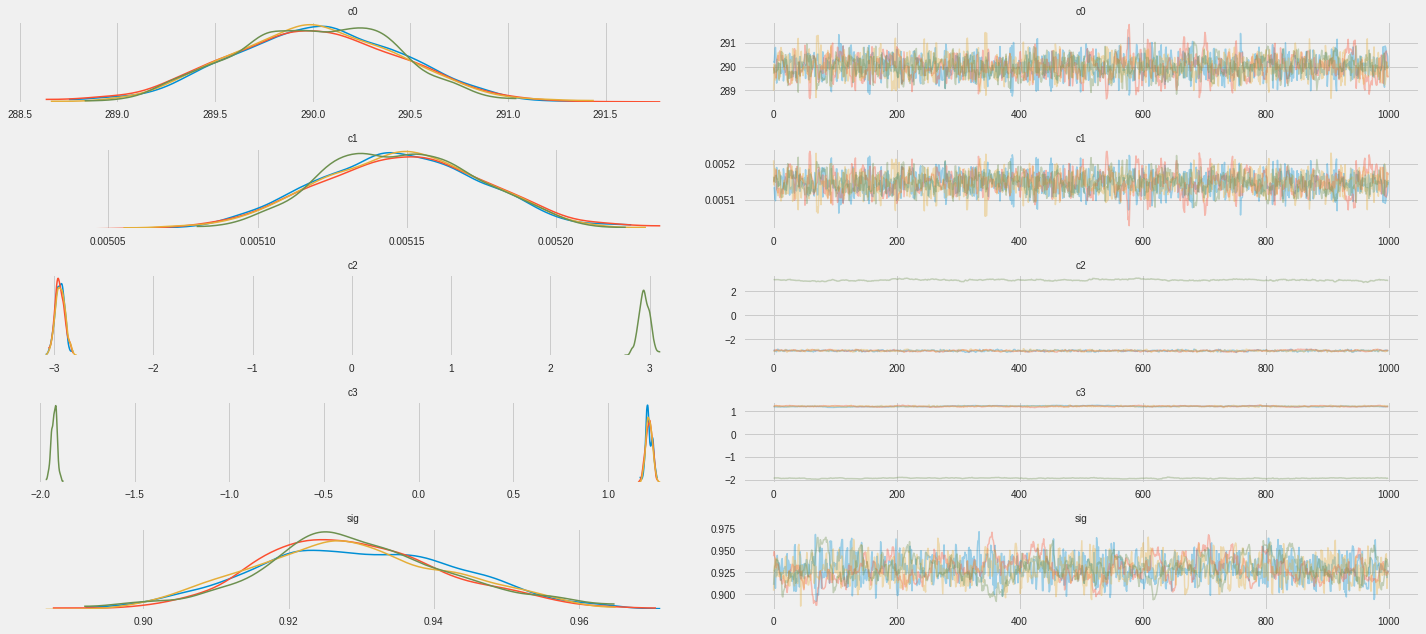


---------------------------Autocorrelation plots------------------------------



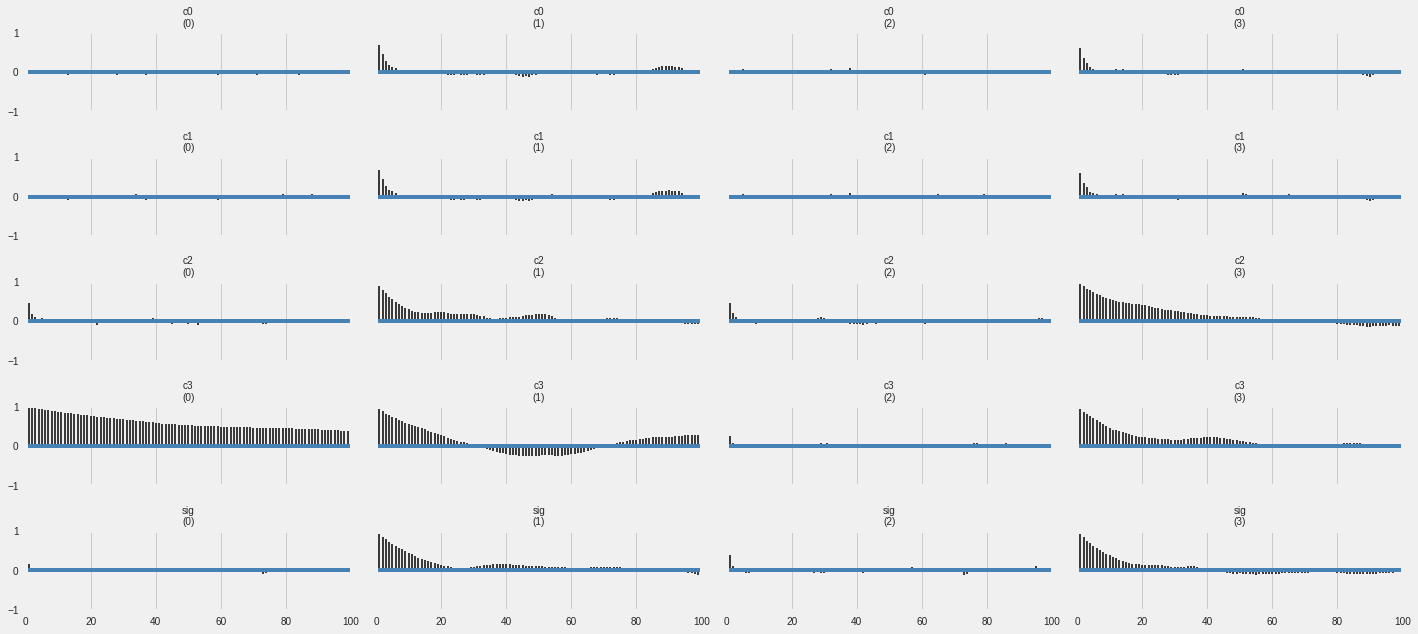


##########################################################################################################


##################################### POSTERIOR PLOTS ########################################



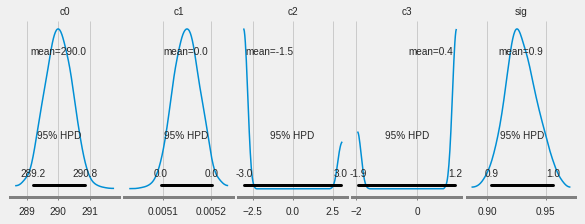


##########################################################################################################



In [237]:
full_analysis(x, y, fit, samples)

REGRESSION LINE: y= 0.005147788386806511x + 290.0053300574432
Model fitted: y =  290.0053300574432 + x * 0.005147788386806511+ np.cos(((2* 3.142 * x)/365.25)+1.209500393166504) * -2.9182575963014066 



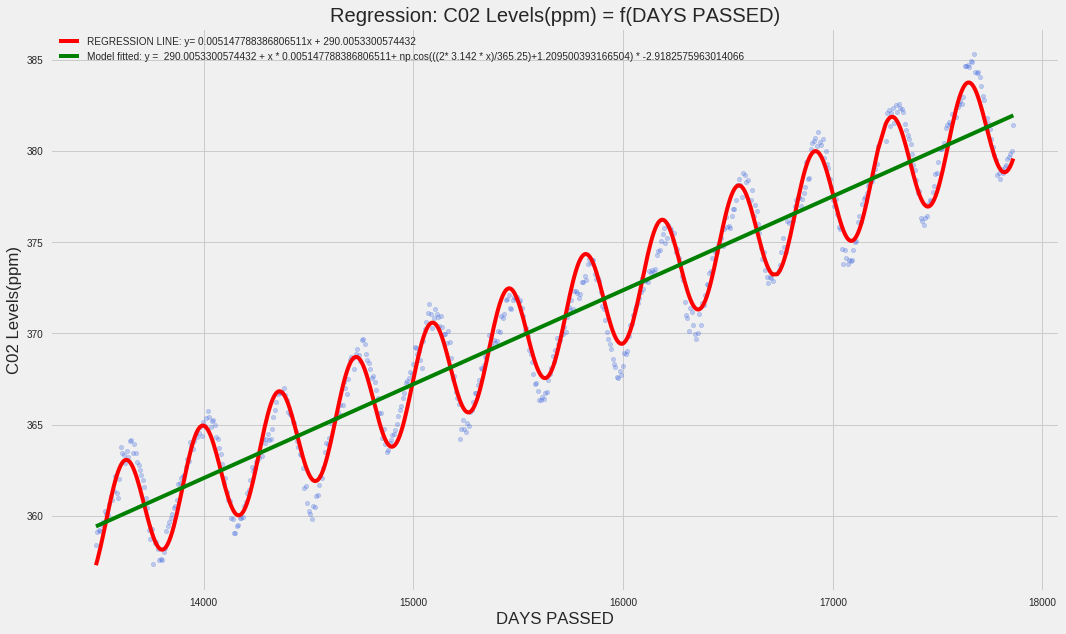

In [238]:
regression_plot(x, fit)

In this one, our autocorrelation in C3 is extremely apparent. The values are definitely interdependent. There were chains stuck in peaks,. Nonetheless, we still get a relatively good fit and so I will trust roll with this model. The gradient increase is still apparent.

In [239]:
norm_lg(x)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     4984.
Date:                Thu, 20 Dec 2018   Prob (F-statistic):          3.69e-297
Time:                        23:19:51   Log-Likelihood:                -1373.9
No. Observations:                 617   AIC:                             2752.
Df Residuals:                     615   BIC:                             2761.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        291.3195      1.126    258.684      0.0

# CHUNK 5

In [0]:
df =df5
x = df['DAYS PASSED'].astype(float).values
y = df['C02 Levels'].astype(float).values
#x_mat = np.array([x1,x2,x3,x4,x5])
data = {'r': len(x),'mu':np.mean(x),'sigma':np.std(x) ,'t':x.transpose(), 'y': y}

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


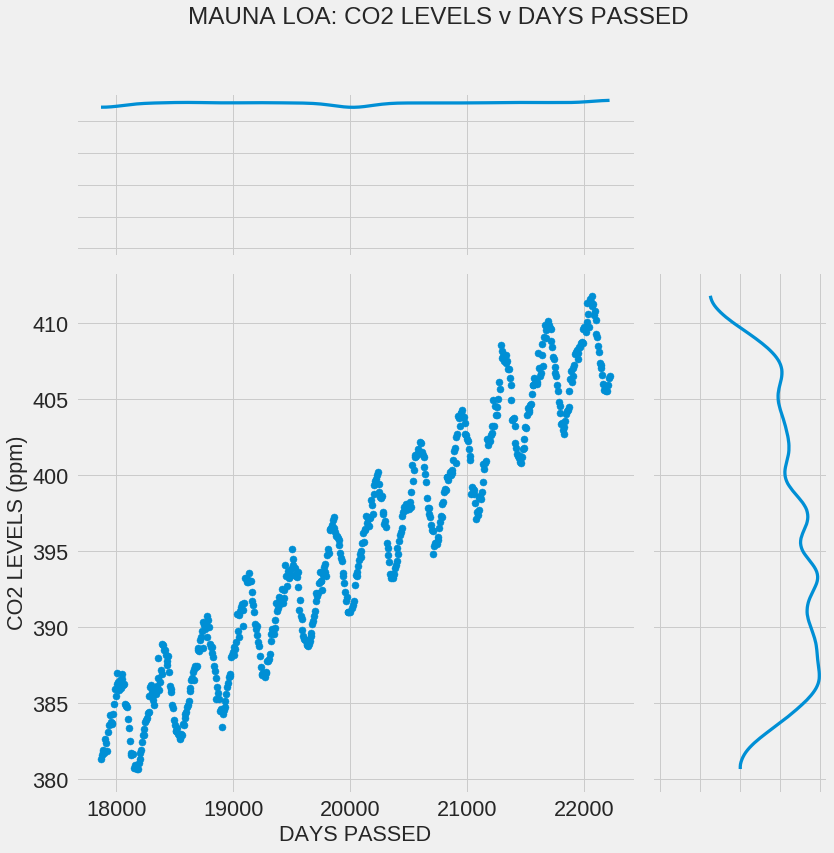

In [241]:
plot_data(x, y)

In [242]:
data = {'r': len(x),'mu':np.mean(x),'sigma':np.std(x) ,'t':np.array(list(x)).reshape(len(x), 1), 'y': y}
fit = model.sampling(data=data, iter=2000, chains=4)
samples = fit.extract()

In [243]:
main_diag(x, fit)

n_eff         False
Rhat          False
divergence     True
treedepth     False
energy         True
dtype: bool
Inference for Stan model: anon_model_67482ab00170209e25c4ba7efe29cf78.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c2[1]   1.51    1.84    2.6  -3.07  -0.29   2.99   3.04   3.11      2  56.18
c3      0.43    1.84   2.61  -1.96  -1.93  -0.35   2.93   4.38      2 167.85
c0    268.98    0.03   0.63 267.72 268.56 268.98 269.42 270.14    329    1.0
c1[1] 6.3e-3  1.7e-6 3.1e-5 6.2e-3 6.3e-3 6.3e-3 6.3e-3 6.4e-3    329    1.0
sig     0.96  1.0e-3   0.01   0.94   0.95   0.96   0.97   0.99    190   1.01
lp__  -257.5    0.08   1.53 -261.2 -258.4 -257.2 -256.3 -255.4    417   1.01

Samples were drawn using NUTS at Thu Dec 20 23:28:29 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential sca


#############################################GENERAL DIAGNOSTICS#############################################

---------------------- inference data for ArviZ-----------------------------

<xarray.Dataset>
Dimensions:  (metric: 7)
Coordinates:
  * metric   (metric) <U22 'mean' ... 'gelman-rubin statistic'
Data variables:
    c0       (metric) float64 269.0 0.6252 0.03575 267.8 270.1 329.0 1.0
    c1       (metric) float64 0.006303 3.112e-05 1.778e-06 ... 328.5 1.0
    c2       (metric) float64 1.513 2.605 0.8491 -3.05 3.108 2.002 58.92
    c3       (metric) float64 0.4252 2.606 1.089 -1.96 4.372 2.001 178.9
    sig      (metric) float64 0.9631 0.01406 0.000349 0.9386 0.9903 189.9 1.0

 ---------------------- Further explore diagnostics: ENERGY LEVELS-----------------------------


Any divergences: False

Check energy greater than 0.3 ...
1.0077445022306202

---------------------- Density and trace plot the results-------------------------



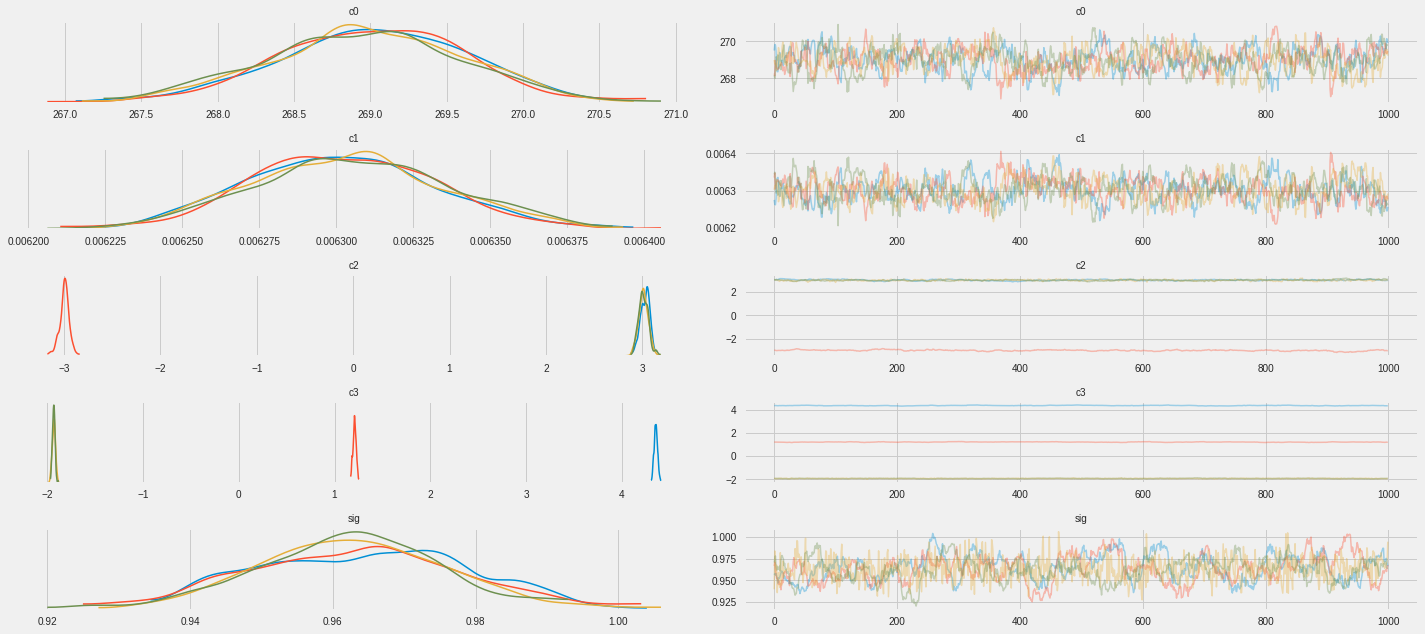


---------------------------Autocorrelation plots------------------------------



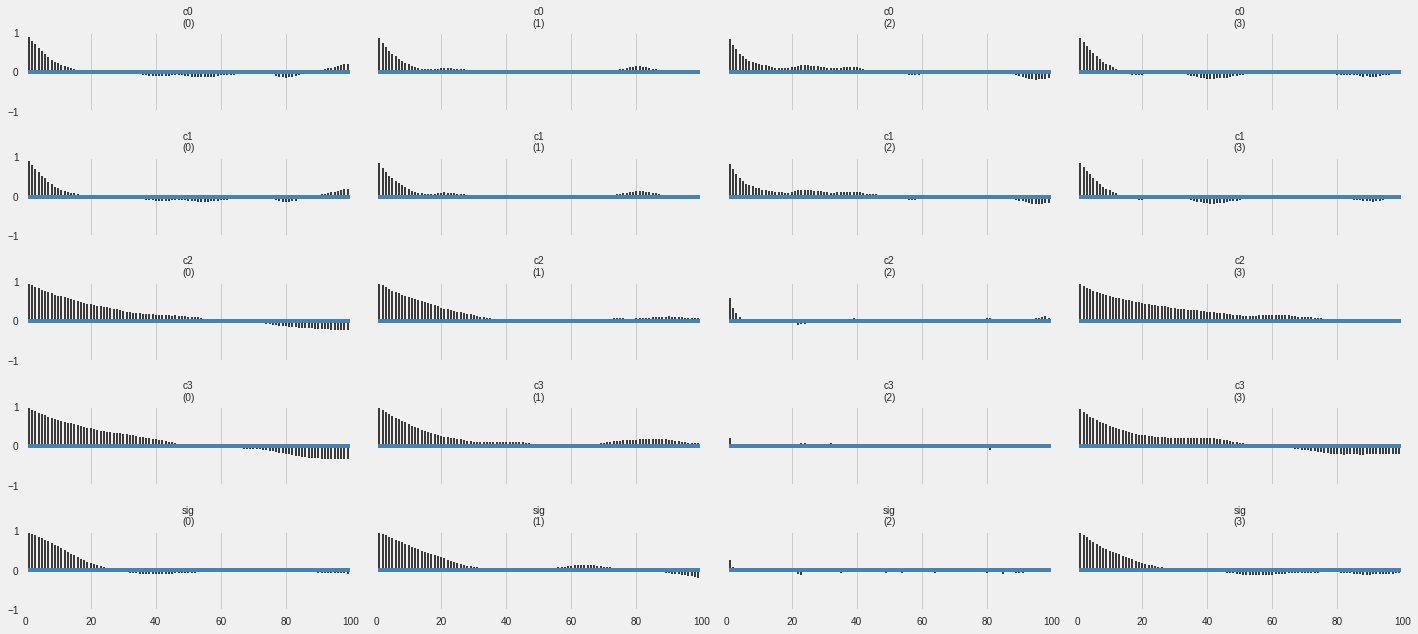


##########################################################################################################


##################################### POSTERIOR PLOTS ########################################



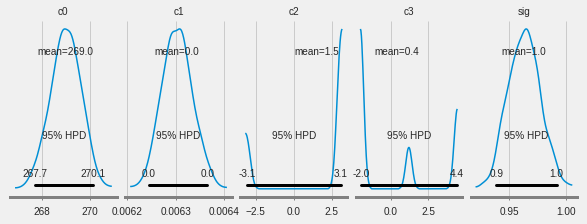


##########################################################################################################



In [244]:
full_analysis(x, y, fit, samples)

REGRESSION LINE: y= 0.0063023358298243785x + 268.9818685142021
Model fitted: y =  268.9818685142021 + x * 0.0063023358298243785+ np.cos(((2* 3.142 * x)/365.25)+-0.3532824176826165) * 2.994771677793285 



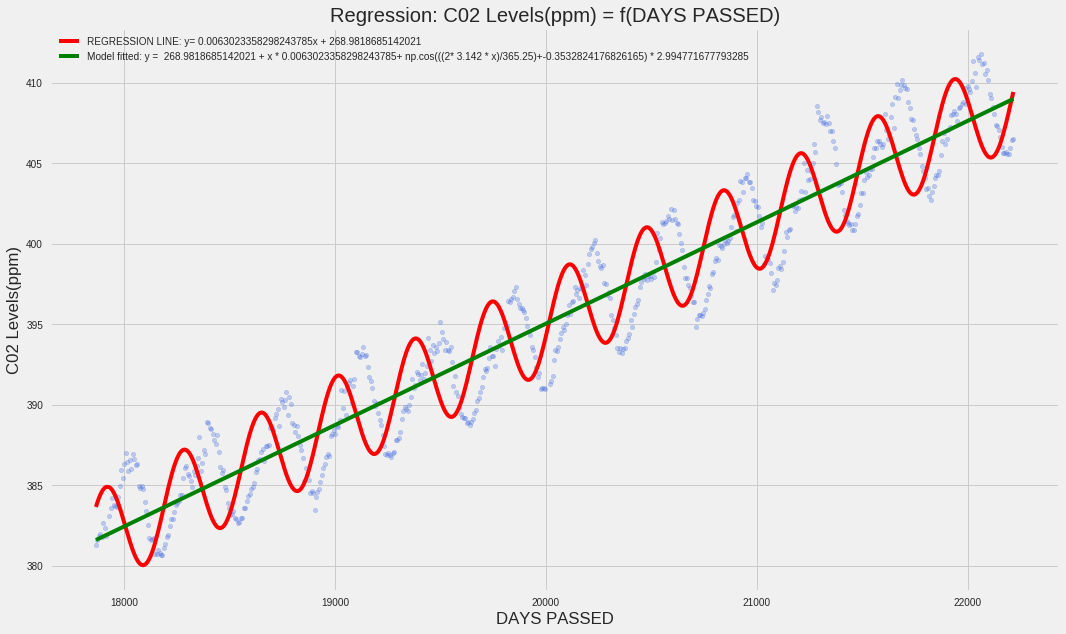

In [245]:
regression_plot(x, fit)

A similar trend. The autocorrelation in this was more insane. 

The model is relatively good so we will still roll with it.
 A quick note, the rate oif change of gradient changed a lot over the last 3 chunks. This indicates a pike in the CO2 rate the past 50 years than those before. Nonetheless, to keep things simple, we will assume this increase rate is negligible and will be accounted for by the normal estimation. In fact, I will try and bias the sample distribution for our predicted coefficients.

In [246]:
norm_lg(x)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     7125.
Date:                Thu, 20 Dec 2018   Prob (F-statistic):               0.00
Time:                        23:28:39   Log-Likelihood:                -1397.6
No. Observations:                 619   AIC:                             2799.
Df Residuals:                     617   BIC:                             2808.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        269.9549      1.488    181.367      0.0

# COMBINATION AND EXTRAPOLATION.

We now have models of straight lines from fitted regressions that can be combined into to give us a sense of the curvature of the data.


![alt text](https://www.wikihow.com/images/thumb/6/6b/Draw-a-Parabolic-Curve-%28a-Curve-with-Straight-Lines%29-Step-12.jpg/aid5583818-v4-728px-Draw-a-Parabolic-Curve-%28a-Curve-with-Straight-Lines%29-Step-12.jpg)

We now have 4 Lines to work with:

## Chunk 1:

Regression: y= 0.0022905500081122424x + 314.556717361755

Model: y =  314.556717361755 + x * 0.0022905500081122424+ np.cos(((2* 3.142 * x)/365.25)+1.1685491360976519) * -2.571065998069873

## Chunk 2:

Regression: y= 0.0037079517438362865x + 307.84399223487077

Model: y =  307.84399223487077 + x * 0.0037079517438362865+ np.cos(((2* 3.142 * x)/365.25)+1.1436171712372687) * -2.780431440545609 

## Chunk 3:

Regression: y= 0.004058880316671683x + 305.3506634535947

Model: y =  305.3506634535947 + x * 0.004058880316671683+ np.cos(((2* 3.142 * x)/365.25)+-1.9636040939429324) * 2.947315076682325 

## Chunk 4:

Regression:  y= 0.005147788386806511x + 290.0053300574432

Model : y =  290.0053300574432 + x * 0.005147788386806511+ np.cos(((2* 3.142 * x)/365.25)+1.209500393166504) * -2.9182575963014066 

## Chunk 5:

Regression:  y= 0.0063023358298243785x + 268.9818685142021

Model: y =  268.9818685142021 + x * 0.0063023358298243785+ np.cos(((2* 3.142 * x)/365.25)+-0.3532824176826165) * 2.994771677793285 


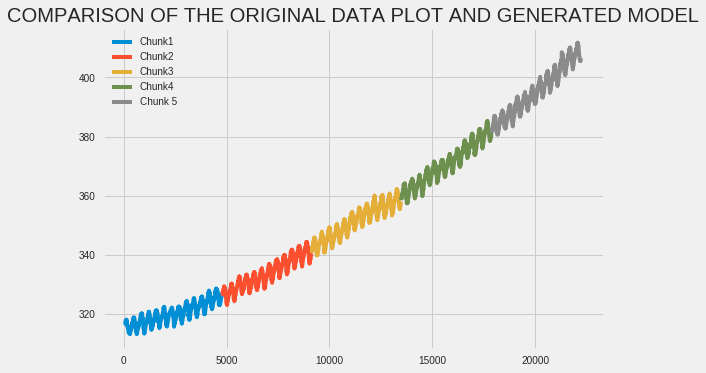

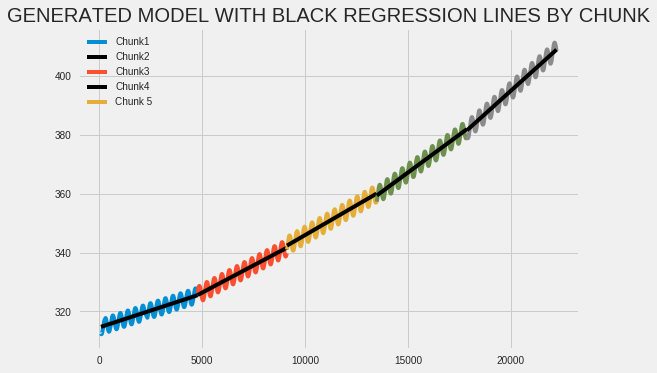

In [332]:
line1 = lambda x:0.0022905500081122424*x + 314.556717361755
reg1 = lambda x: 314.556717361755 + x*0.0022905500081122424+ np.cos(((2*3.142*x)/365.25)+1.1685491360976519)*2.571065998069873

line2 = lambda x:0.0037079517438362865*x + 307.84399223487077
reg2 = lambda x: 307.84399223487077 + x *0.0037079517438362865+ np.cos(((2*3.142*x)/365.25)+1.1436171712372687)* -2.780431440545609

line3 = lambda x: 0.004058880316671683*x + 305.3506634535947
reg3 = lambda x: 305.3506634535947 + x*0.004058880316671683+ np.cos(((2* 3.142*x)/365.25)+-1.9636040939429324)*2.947315076682325

line4 = lambda x: 0.005147788386806511*x + 290.0053300574432
reg4 = lambda x: 290.0053300574432 + x*0.005147788386806511+ np.cos(((2* 3.142*x)/365.25)+1.209500393166504)* -2.9182575963014066

line5 = lambda x: 0.0063023358298243785*x + 268.9818685142021
reg5 = lambda x: 268.9818685142021 + x*0.0063023358298243785+ np.cos(((2* 3.142*x)/365.25)+-0.3532824176826165)*-2.994771677793285


def vals_getter(df):
  x = df['DAYS PASSED'].astype(float).values
  y = df['C02 Levels'].astype(float).values
  return x, y

x1, y1 = vals_getter(df1)
ln1, rg1 = [line1(i) for i in x1], [reg1(i) for i in x1]

x2, y2 = vals_getter(df2)
ln2, rg2 = [line2(i) for i in x2], [reg2(i) for i in x2]

x3, y3 = vals_getter(df3)
ln3, rg3 = [line3(i) for i in x3], [reg3(i) for i in x3]

x4, y4 = vals_getter(df4)
ln4, rg4 = [line4(i) for i in x4], [reg4(i) for i in x4]

x5, y5 = vals_getter(df5)
ln5, rg5 = [line5(i) for i in x5], [reg5(i) for i in x5]


f, ax = plt.subplots(1)
f2, ax2 = plt.subplots(1)
ax.plot(x1, y1)
ax2.plot(x1, rg1)
ax2.plot(x1, ln1, color = "black")

ax.plot(x2, y2)
ax2.plot(x2, rg2)
ax2.plot(x2, ln2, color = "black")

ax.plot(x3, y3)
ax2.plot(x3, rg3)
ax2.plot(x3, ln3, color = "black")

ax.plot(x4, y4)
ax2.plot(x4, rg4)
ax2.plot(x4, ln4, color = "black")

ax.plot(x5, y5)
ax2.plot(x5, rg5)
ax2.plot(x5, ln5, color = "black")

ax.legend(['Chunk1', 'Chunk2', 'Chunk3', 'Chunk4', 'Chunk 5'])
ax2.legend(['Chunk1', 'Chunk2', 'Chunk3', 'Chunk4', 'Chunk 5'])
ax.set_title("COMPARISON OF THE ORIGINAL DATA PLOT AND GENERATED MODEL")
ax2.set_title("GENERATED MODEL WITH BLACK REGRESSION LINES BY CHUNK")

plt.show()




Our new plot is waay better than the orginal one..We achieved some non linearity with linear lines. And now to estimate a new chunk: 

We need to first come up with the regression lineas. The changes have been as follows:



In [307]:
#c0 + t*c1 + cos(((2* 3.142 *t)/365.25)+c3)*c2
c0s = [314.556717361755, 307.84399223487077,  305.3506634535947,  290.0053300574432, 268.9818685142021]
c1s=[0.0022905500081122424,0.0037079517438362865, 0.004058880316671683,0.005147788386806511, 0.0063023358298243785]
c2s = [2.571065998069873, -2.780431440545609, 2.947315076682325, -2.9182575963014066, -2.994771677793285] #Fluctuates between -ve and +ve
c3s = [1.1685491360976519, 1.1436171712372687, -1.9636040939429324,1.209500393166504, -0.3532824176826165]

sigs = [0.87, 0.86,0.97, 0.93, 0.96]


def genVals(data):
  mu, sig = np.mean(data), np.std(data)
  return np.random.normal(mu*1.1, sig*1.1, 1)

c0g, c1g, c2g, c3g, signg = genVals(c0s),genVals(c1s),np.random.choice([-1,1])*genVals([abs(c) for c in c2s]),genVals(c3s),genVals(sigs)

print(f"FUTURE Linear Regression : y = {c0g}x+")
print(f"FUTURE Model : {c0g} + {c1g}x + cos(((2* 3.142 *x)/365.25)+{c3g})*{c2g}")

FUTURE Linear Regression : y = [337.72169072]x+
FUTURE Model : [337.72169072] + [0.0040779]x + cos(((2* 3.142 *x)/365.25)+[0.38545572])*[3.27439549]


Now let us project the days from the final day to the start of 2058.

This is 40*365.25 days = 14610 days.

We will generate the weekly days using a loop with 7 steps:
0

In [0]:
future_dates = [i for i in range(int(x[-1]), int(x[-1])+14610, 7)]

Now to create the necessary lines and models for projection:

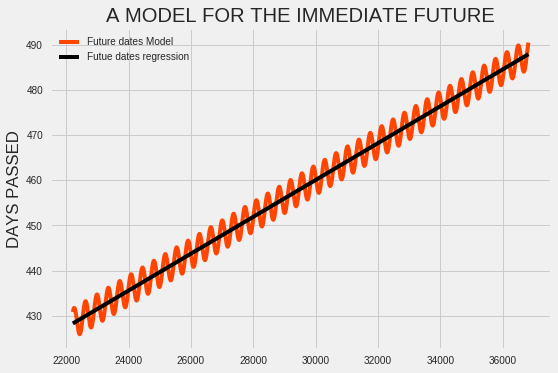

At the start of 2048, in 40 years, the C02 levels will be about:490.4487528027913 ppm


In [347]:
line_reg_future = lambda x:  c0g + c1g*x + np.cos(((2* 3.142 *x)/365.25)+c3g)*c2g
line_ln_future = lambda x:  c0g + c1g*x

future_C02_reg = [line_reg_future(d) for d in future_dates]
future_C02_line = [line_ln_future(d) for d in future_dates]

f, ax = plt.subplots(1)
ax.plot(future_dates, future_C02_reg, color = "orangered")
ax.plot(future_dates, future_C02_line, color = "black")
ax.legend(["Future dates Model", "Futue dates regression"])
ax.set_title("A MODEL FOR THE IMMEDIATE FUTURE")
ax.set_ylabel("Predicted CO2 levels(ppm)")
ax.set_ylabel("DAYS PASSED")
plt.show()

print(f"At the start of 2048, in 40 years, the C02 levels will be about:{np.mean([future_C02_reg[-1], future_C02_reg[-1]])} ppm")

So the estimated level at the start of 2058 is 490.4488 ppm.

With our sigma and estimate above, lets generate a normal plot with the 95% confidence intervals.

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

lower, upper = stats.norm.interval(0.95, loc=490.45, scale=0.90)
print(f"Lower confidence interval : {lower}, Upper Confidence Interval {upper}")

Lower confidence interval : 488.68603241391395, Upper Confidence Interval 492.213967586086


So there we go: The confidence intervals for the start of 2058 are:
## Lower confidence interval : 488.68603241391395, Upper Confidence Interval 492.213967586086: 

# TASKS:

##Identify some of the flaws with the model in the example above and to come up with something better

The linearity of the intiial model ignored the clearly non linear trend that the data shower. I personally liked the seasonal fluctuations and though that modelling them using a cosine with induced  noise made sense so I stuck by this but this linearity accross the whole dataset ignored the increasing gradient in the rate of C02 increase. 

### Improvement.

I noticed the linear model performed well with smalll datasets so I used chunks of the dataset leading up the the present. This trend gave me an idea of how the rate was changing and so I created a model for the next 40 years based on this information.

This is still imperfect as we fail to capture the quadratic trend.  Nonetheless, it is a relatively accurate approximation and in fact, we we to do this with small enough chunks, we would get an estimate as accurate as the quadratic estimate.

## Do inference in your model using R or Python, to get approximate posterior distributions over all your model parameters,

All through the implementation, I have created plots of the posteriors to ensure they are well noted.  I did not discuss them since they were straight forward and I included print statements to label them so as to indicate that I know what they are. Hopefully this serves well to answer this section.

## use your posteriors to forecast what atmospheric CO2 levels at Mauna Loa will be for the next 40 years

I created the plot for this above and used it to make predictions for the start of 2058, which will be about the 36610th day.

The predicted C02 levels at the start are 490.4488 ppm.

## What is your best estimate for atmospheric CO2 levels projected until the start of 2058?

The plot is above, the predicticted level is 490.4488 ppm

# What is your 95% confidence interval for atmospheric CO2 levels projected until the start of 2058?

Lower confidence interval : 488.68603241391395, Upper Confidence Interval 492.213967586086:

GRAPH BELOW:

# CO2 levels of 450 ppm is considered high risk for dangerous climate change. By when is there a strong probability that will we reach those levels? Use your model to answer this question, but present the results in a way that someone unfamiliar with statistics will understand

I have plots from which we can infer this. The first time we hit a 450 peak is at around day 27000. (I can give the exact number since my colab crushed and I do not want to lose my cached model and the already output results I have based my answer on)

With day 27000 as the estimate, this is 75 years after 1958 which is around 2033..

#Analyze the main shortcomings of your model. Where is there room for improvement? Explore the statistical differences between your model and the real data.


The model assumes linearly which is not right. It also assumes a constant rate of change of C02 concentrations. It suffices either way since the data is slightly quadratic but not so enough to make a linear model shoddy especially in short term intervals. The overall trend to me is quadratic (But this I know only because I have seen the exact formula [from here ](http://www.seos-project.eu/modules/timeseries/images/TS02a.png)

My intutition however tells me it is somewha **EXPONENTIAL** given the changing rate of cange of the rate of CO2 increase. It is still however, possible to model it with a quadratic. Simply put, it is NOT LINEAR.



## Improvements on my model

1. Actually fitting the non linear trend (Mine attempts failed to work and I ran our of time hence why I chose to approximate it)
2. Better and more informative priors: I used broad priors relativel to the data for the covariates but more informative priors could be used given that we have some informatiion. Specifically, C2 and sigma could have been defined by more specific priors that reflect their distribution.